In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import show
import seaborn as sns
import pymc as pm
import bambi as bmb
import arviz as az
from scipy import stats
from scipy.special import expit
import os
cwd = os.getcwd()
import warnings
warnings.filterwarnings('ignore')
import R2_Bayes as r2

In [3]:
DF= pd.read_csv(cwd[:-4]+'/Data/counties_data_2012_2022.csv', low_memory= False)

In [4]:
DF.columns[-30:]

Index(['subsidy_ratio', 'indemnity_avg', 'State', 'state_abb', 'Region',
       'Region_fips', 'tavg_mean', 'tavg_std', 'edd_mean', 'edd_std',
       'pcp_mm_mean', 'pcp_mm_std', 'pcpdays_mean', 'pcpdays_std',
       'tavg_mean_base', 'tavg_std_base', 'edd_mean_base', 'edd_std_base',
       'pcp_mm_mean_base', 'pcp_mm_std_base', 'pcpdays_mean_base',
       'pcpdays_std_base', 'tavg_z', 'edd_z', 'pcp_mm_z', 'pcpdays_z',
       'cc_acres', 'cc_ope', 'cc_acres_tot', 'cc_ope_tot'],
      dtype='object')

In [5]:
DF= DF[DF.State!= 'Hawaii']#[['county_fips','state_fips','State','state_abb', 'Region_fips']]

In [6]:
DF['Region_name']= DF['Region']
DF['Region']= DF['Region_name']
DF= pd.get_dummies(DF, columns=['Region'])

In [7]:
DF['year_2017'] = np.where(DF['year']==2017, 1, 0)
DF['year_2022'] = np.where(DF['year']==2022, 1, 0)

In [8]:
DF.replace([np.inf, -np.inf], np.nan, inplace=True)


In [9]:
DF.dropna(axis=0, how='any',subset=['covercrop_acres',
            'women_acres', #demographics
         'labor_expense','org_ope', #farm management
            'pasture_cropland', 'irrigated_harvcrop_ope','entropy', 
            'cons_prog_income','noncons_prog_income','state_prog_ope','insurance_acres','subsidy_ratio',
            'individual', 'human', 'regulate', #opinion
            'tavg_std', 'edd_mean', #weather
            'pcp_mm_std', 'pcpdays_mean',
            'tavg_z', 'pcp_mm_z'], inplace=True)

In [10]:
def dfsummary(trace):
    dfy= az.summary(trace)
    dfy['variables'] =dfy.index
    dfy['region']= dfy.variables.str[-2:-1]
    
    return dfy

In [11]:
# Keep counties with at least 2 observations
DF.sort_values(by= ['county_fips','year'], inplace=True)
DF['cons']=1
DF['times']= DF.groupby(['county_fips'])['cons'].transform(sum)

In [12]:
norm_vars= ['covercrop_acres',
            'women_acres',#demographics
            'labor_expense', 'org_ope', #farm management
            'pasture_cropland', 'irrigated_harvcrop_ope','entropy', 
            'cons_prog_income','noncons_prog_income','state_prog_ope','insurance_acres','subsidy_ratio',
            'individual', 'human', 'regulate', #opinion
            'tavg_std', 'edd_mean', #weather
            'pcp_mm_std', 'pcpdays_mean',
            'tavg_z', 'pcp_mm_z'
           ]

DF.replace([np.inf, -np.inf], np.nan, inplace=True)

DF1= DF[['times','year_2017','year_2022','county_fips', 'state_fips', 'year','Region_name','Region_fips', 
         'Region_Midwest', 'Region_Northeast',
       'Region_Northern Plains', 'Region_Northwest', 'Region_Southeast',
       'Region_Southern Plains', 'Region_Southwest']+ norm_vars]
DF1= DF1[DF1['times']>1]
#DF1['covercrop_acres'].replace(0, 0.001, inplace=True) # replace zero for tiny values

for x in norm_vars:
    DF1[x+'_diff']= DF1[x] - DF1.groupby(['county_fips'])[x].transform('mean')

(array([  8.,  13.,   9.,  21.,  31.,  27.,  40.,  47.,  46.,  48.,  51.,
        108., 285., 303., 314., 317., 320., 299., 334., 312., 313., 278.,
        321., 309., 275., 262., 237., 212., 169., 156., 122.,  78.,  81.,
         50.,  32.,  25.,  16.,  14.,  11.,   9.,   6.,  10.,   6.,   4.,
          4.,   3.,   3.,   1.,   0.,   1.]),
 array([0.02793045, 0.0850808 , 0.14223114, 0.19938149, 0.25653184,
        0.31368218, 0.37083253, 0.42798288, 0.48513322, 0.54228357,
        0.59943391, 0.65658426, 0.71373461, 0.77088495, 0.8280353 ,
        0.88518565, 0.94233599, 0.99948634, 1.05663668, 1.11378703,
        1.17093738, 1.22808772, 1.28523807, 1.34238842, 1.39953876,
        1.45668911, 1.51383946, 1.5709898 , 1.62814015, 1.68529049,
        1.74244084, 1.79959119, 1.85674153, 1.91389188, 1.97104223,
        2.02819257, 2.08534292, 2.14249327, 2.19964361, 2.25679396,
        2.3139443 , 2.37109465, 2.428245  , 2.48539534, 2.54254569,
        2.59969604, 2.65684638, 2.71399673, 2.

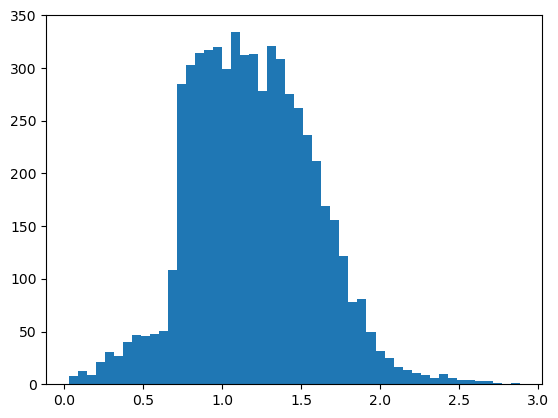

In [13]:
plt.hist(DF1['entropy'], bins=50)

In [14]:
DF1[['county_fips','covercrop_acres_diff','women_acres_diff', #demographics
            'labor_expense_diff','org_ope_diff', #farm management
            'pasture_cropland_diff','irrigated_harvcrop_ope_diff', 'entropy_diff', 
            'cons_prog_income_diff','noncons_prog_income_diff','state_prog_ope_diff','insurance_acres_diff',
            'subsidy_ratio_diff',
            'individual_diff', 'human_diff', 'regulate_diff', #opinion
            'tavg_std_diff', 'edd_mean_diff',
            'pcp_mm_std_diff', 'pcpdays_mean_diff',
            'tavg_z_diff', 'pcp_mm_z_diff']]

,county_fips,covercrop_acres_diff,women_acres_diff,labor_expense_diff,org_ope_diff,pasture_cropland_diff,irrigated_harvcrop_ope_diff,entropy_diff,cons_prog_income_diff,noncons_prog_income_diff,...,subsidy_ratio_diff,individual_diff,human_diff,regulate_diff,tavg_std_diff,edd_mean_diff,pcp_mm_std_diff,pcpdays_mean_diff,tavg_z_diff,pcp_mm_z_diff
0,1001,-0.030113,-0.087938,-0.018850,0.000000,0.045766,0.018012,0.096324,0.036139,0.175124,...,0.024634,-0.035800,-0.017367,0.008000,0.055299,-2.933333,59.775672,0.200000,0.125826,-0.319990
67,1001,-0.014051,0.023091,-0.023144,0.000000,-0.037039,-0.045215,-0.117940,-0.037258,-0.141475,...,-0.006250,-0.002300,0.022333,0.022400,-0.019449,-0.733333,-57.926263,-0.600000,-0.284718,-0.079405
134,1001,0.044164,0.064847,0.041994,0.000000,-0.008727,0.027203,0.021616,0.001118,-0.033649,...,-0.018384,0.038100,-0.004967,-0.030400,-0.035849,3.666667,-1.849409,0.400000,0.158892,0.399395
1,1003,-0.052416,-0.056814,-0.028803,0.004611,-0.054352,-0.009055,-0.056418,0.055810,-0.355640,...,0.003877,-0.032767,-0.010367,0.021833,-0.030577,-1.800000,56.558201,-1.000000,0.326565,-0.396072
68,1003,0.128202,0.007398,-0.009927,-0.003478,-0.016784,-0.036688,-0.008936,-0.010864,0.900049,...,-0.000768,-0.004017,0.020933,0.018733,0.058223,-1.400000,-15.335013,1.400000,-0.281573,0.306542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9169,56043,-0.027876,-0.033822,-0.013313,0.000000,-0.055015,-0.028136,-0.037042,0.003713,-0.451956,...,-0.017879,-0.033917,-0.021467,0.000633,0.447242,-5.066667,15.404258,-0.133333,-0.387961,-0.285197
9192,56043,0.000987,-0.013721,0.013029,0.000000,0.062368,-0.008375,-0.021816,-0.008227,-0.591494,...,-0.029801,0.004733,0.042733,0.041333,-0.199148,0.733333,-33.544123,0.066667,0.281288,0.578375
9215,56043,0.026890,0.047542,0.000284,0.000000,-0.007353,0.036511,0.058858,0.004514,1.043450,...,0.047681,0.029183,-0.021267,-0.041967,-0.248094,4.333333,18.139865,0.066667,0.106673,-0.293178
9170,56045,0.020156,-0.074055,-0.019695,0.000000,0.029957,0.053552,-0.153525,-0.002445,-0.013070,...,0.011495,-0.023200,-0.025700,-0.019650,0.454290,-0.700000,9.429182,-0.100000,-0.176161,-0.117130


## Pooled Model

In [14]:
sigma1= 1

priorsp={
    'women_acres_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'labor_expense_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'org_ope_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pasture_cropland_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'irrigated_harvcrop_ope_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'state_prog_ope_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'entropy_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'cons_prog_income_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'insurance_acres_diff': bmb.Prior("Laplace", mu=0, b=sigma1),    
    'noncons_prog_income_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'subsidy_ratio_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'individual_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'human_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'regulate_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'tavg_std_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'edd_mean_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_std_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcpdays_mean_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'tavg_z_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_z_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'year_2017': bmb.Prior('Laplace', mu=0, b= sigma1),
    'year_2022': bmb.Prior('Laplace', mu=0, b= sigma1),
    'sigma': bmb.Prior('HalfCauchy', beta= 1)
        }

In [15]:
modelccp = bmb.Model("covercrop_acres_diff ~ 0+\
            (cons_prog_income_diff)+(noncons_prog_income_diff)+(state_prog_ope_diff)+\
            (insurance_acres_diff)+(subsidy_ratio_diff)+\
            (edd_mean_diff)+(pcpdays_mean_diff)+\
            (tavg_std_diff)+(pcp_mm_std_diff)+\
            (tavg_z_diff)+(pcp_mm_z_diff)+\
            (women_acres_diff)+(labor_expense_diff)+(org_ope_diff)+\
            (pasture_cropland_diff)+(irrigated_harvcrop_ope_diff)+(entropy_diff)+\
            (individual_diff)+(human_diff)+(regulate_diff)+\
            (year_2017)+ (year_2022)",
            DF1, priors=priorsp, dropna=True)
modelccp

Formula: covercrop_acres_diff ~ 0+            (cons_prog_income_diff)+(noncons_prog_income_diff)+(state_prog_ope_diff)+            (insurance_acres_diff)+(subsidy_ratio_diff)+            (edd_mean_diff)+(pcpdays_mean_diff)+            (tavg_std_diff)+(pcp_mm_std_diff)+            (tavg_z_diff)+(pcp_mm_z_diff)+            (women_acres_diff)+(labor_expense_diff)+(org_ope_diff)+            (pasture_cropland_diff)+(irrigated_harvcrop_ope_diff)+(entropy_diff)+            (individual_diff)+(human_diff)+(regulate_diff)+            (year_2017)+ (year_2022)
Family name: Gaussian
Link: identity
Observations: 5941
Priors:
  Common-level effects
    cons_prog_income_diff ~ Laplace(mu: 0, b: 1)
    noncons_prog_income_diff ~ Laplace(mu: 0, b: 1)
    state_prog_ope_diff ~ Laplace(mu: 0, b: 1)
    insurance_acres_diff ~ Laplace(mu: 0, b: 1)
    subsidy_ratio_diff ~ Laplace(mu: 0, b: 1)
    edd_mean_diff ~ Laplace(mu: 0, b: 1)
    pcpdays_mean_diff ~ Laplace(mu: 0, b: 1)
    tavg_std_diff ~ Laplace(mu

In [44]:
trace_ccp = modelccp.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.95,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [covercrop_acres_diff_sigma, year_2022, year_2017, regulate_diff, human_diff, individual_diff, entropy_diff, irrigated_harvcrop_ope_diff, pasture_cropland_diff, org_ope_diff, labor_expense_diff, women_acres_diff, pcp_mm_z_diff, tavg_z_diff, pcp_mm_std_diff, tavg_std_diff, pcpdays_mean_diff, edd_mean_diff, subsidy_ratio_diff, insurance_acres_diff, state_prog_ope_diff, noncons_prog_income_diff, cons_prog_income_diff]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 164 seconds.


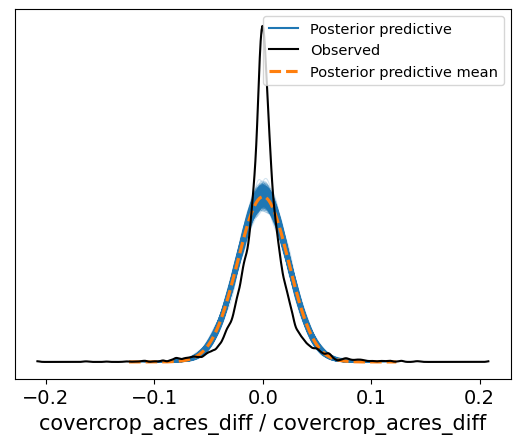

In [17]:
modelccp.predict(trace_ccp, kind="pps")
az.plot_ppc(trace_ccp);

In [45]:
az.summary(trace_ccp)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cons_prog_income_diff,0.005,0.005,-0.004,0.014,0.000,0.000,4689.0,2922.0,1.0
noncons_prog_income_diff,-0.001,0.001,-0.003,0.001,0.000,0.000,5723.0,2580.0,1.0
state_prog_ope_diff,0.014,1.432,-2.923,2.730,0.024,0.029,4436.0,1909.0,1.0
insurance_acres_diff,0.046,0.008,0.031,0.060,0.000,0.000,5693.0,3131.0,1.0
subsidy_ratio_diff,-0.034,0.024,-0.080,0.011,0.000,0.000,6335.0,3073.0,1.0
edd_mean_diff,0.000,0.000,-0.000,0.000,0.000,0.000,3216.0,2979.0,1.0
pcpdays_mean_diff,0.000,0.000,-0.001,0.001,0.000,0.000,3841.0,3132.0,1.0
tavg_std_diff,-0.012,0.002,-0.016,-0.008,0.000,0.000,3727.0,3426.0,1.0
pcp_mm_std_diff,-0.000,0.000,-0.000,-0.000,0.000,0.000,7326.0,3338.0,1.0
tavg_z_diff,-0.004,0.001,-0.006,-0.002,0.000,0.000,4277.0,3305.0,1.0


In [49]:
az.loo(trace_ccp)

Computed from 4000 posterior samples and 5841 observations log-likelihood matrix.

         Estimate       SE
elpd_loo 14196.87   128.41
p_loo       35.87        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     5841  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

### Bayes R2

In [46]:
varpost= [
        'cons_prog_income_diff','noncons_prog_income_diff','state_prog_ope_diff','insurance_acres_diff',
            'subsidy_ratio_diff', #policies
            'edd_mean_diff', 'pcpdays_mean_diff',
            'tavg_std_diff','pcp_mm_std_diff',  #weather
            'tavg_z_diff', 'pcp_mm_z_diff',
             'women_acres_diff', #demographics
            'labor_expense_diff','org_ope_diff', #farm management
            'pasture_cropland_diff','irrigated_harvcrop_ope_diff', 'entropy_diff',
            'individual_diff', 'human_diff', 'regulate_diff', #opinion
            'year_2017','year_2022']

varsdf= [
            'cons_prog_income_diff','noncons_prog_income_diff','state_prog_ope_diff','insurance_acres_diff',
            'subsidy_ratio_diff', #policies
            'edd_mean_diff', 'pcpdays_mean_diff',
            'tavg_std_diff','pcp_mm_std_diff',  #weather
            'tavg_z_diff', 'pcp_mm_z_diff',
             'women_acres_diff', #demographics
            'labor_expense_diff','org_ope_diff', #farm management
            'pasture_cropland_diff','irrigated_harvcrop_ope_diff', 'entropy_diff',
            'individual_diff', 'human_diff', 'regulate_diff', #opinion
            'year_2017','year_2022']

DF1_clean= DF1
DF1_clean.dropna(axis=0, how='any',subset=['covercrop_acres_diff',
            'cons_prog_income_diff','noncons_prog_income_diff','state_prog_ope_diff','insurance_acres_diff',
            'subsidy_ratio_diff', #policies
            'edd_mean_diff', 'pcpdays_mean_diff',
            'tavg_std_diff','pcp_mm_std_diff',  #weather
            'tavg_z_diff', 'pcp_mm_z_diff',
             'women_acres_diff', #demographics
            'labor_expense_diff','org_ope_diff', #farm management
            'pasture_cropland_diff','irrigated_harvcrop_ope_diff', 'entropy_diff',
            'individual_diff', 'human_diff', 'regulate_diff', #opinion
            'year_2017','year_2022'], inplace=True)


In [37]:
meanp, lcip, ucip= r2.Bayesian_Rsquared(DF1_clean, 'identity', trace_ccp, 'covercrop_acres_diff',varsdf,varpost, False, x,4,1000,x)


In [38]:
print('Mean CI:', meanp)
print('Lower CI:', lcip)
print('Upper CI:', ucip)

Mean CI: 0.1526560595746734
Lower CI: 0.13773209659488317
Upper CI: 0.16848075650061928


In [47]:

print(az.hdi(trace_ccp,var_names=varpost[:12], hdi_prob = 0.99).values())
print(az.hdi(trace_ccp,var_names=varpost[12:], hdi_prob = 0.99).values())


ValuesView(<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
  * hdi                       (hdi) <U6 'lower' 'higher'
Data variables:
    cons_prog_income_diff     (hdi) float64 -0.008861 0.01715
    noncons_prog_income_diff  (hdi) float64 -0.003689 0.001284
    state_prog_ope_diff       (hdi) float64 -4.83 4.564
    insurance_acres_diff      (hdi) float64 0.02659 0.06547
    subsidy_ratio_diff        (hdi) float64 -0.09359 0.02634
    edd_mean_diff             (hdi) float64 -0.0001315 0.0004104
    pcpdays_mean_diff         (hdi) float64 -0.0009061 0.0009664
    tavg_std_diff             (hdi) float64 -0.01662 -0.00645
    pcp_mm_std_diff           (hdi) float64 -3.088e-05 -2.214e-06
    tavg_z_diff               (hdi) float64 -0.007045 -0.001056
    pcp_mm_z_diff             (hdi) float64 -0.007055 -0.000971
    women_acres_diff          (hdi) float64 0.00599 0.03612)
ValuesView(<xarray.Dataset>
Dimensions:                      (hdi: 2)
Coordinates:
  * hdi        

In [49]:
print(az.hdi(trace_ccp,var_names=varpost[:12], hdi_prob = 0.90).values())
print(az.hdi(trace_ccp,var_names=varpost[12:], hdi_prob = 0.90).values())

ValuesView(<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
  * hdi                       (hdi) <U6 'lower' 'higher'
Data variables:
    cons_prog_income_diff     (hdi) float64 -0.002598 0.01363
    noncons_prog_income_diff  (hdi) float64 -0.002862 0.0003178
    state_prog_ope_diff       (hdi) float64 -2.205 2.392
    insurance_acres_diff      (hdi) float64 0.03216 0.05774
    subsidy_ratio_diff        (hdi) float64 -0.07443 0.004516
    edd_mean_diff             (hdi) float64 -4.58e-05 0.0003115
    pcpdays_mean_diff         (hdi) float64 -0.0004649 0.0007314
    tavg_std_diff             (hdi) float64 -0.01516 -0.00871
    pcp_mm_std_diff           (hdi) float64 -2.617e-05 -7.402e-06
    tavg_z_diff               (hdi) float64 -0.005948 -0.001985
    pcp_mm_z_diff             (hdi) float64 -0.00553 -0.001664
    women_acres_diff          (hdi) float64 0.01228 0.03127)
ValuesView(<xarray.Dataset>
Dimensions:                      (hdi: 2)
Coordinates:
  * hdi       

## Multi-regions

In [21]:
sigma1= 1
priorsr={'1|Region_fips': bmb.Prior("Normal", mu= 0, sigma= sigma1),
    'women_acres_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'labor_expense_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'org_ope_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'irrigated_harvcrop_ope_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pasture_cropland_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'state_prog_ope_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'entropy_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'cons_prog_income_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'insurance_acres_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),    
    'noncons_prog_income_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'subsidy_ratio_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'individual_diff|Region_fips': bmb.Prior("Laplace", mu=0, b= sigma1),
    'human_diff|Region_fips': bmb.Prior("Laplace", mu=0, b= sigma1),
    'regulate_diff|Region_fips': bmb.Prior("Laplace", mu=0, b= sigma1),
    'tavg_std_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'edd_mean_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_std_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcpdays_mean_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'tavg_z_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_z_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'year_2017|Region_fips': bmb.Prior('Laplace', mu=0, b= sigma1),
    'year_2022|Region_fips': bmb.Prior('Laplace', mu=0, b= sigma1),
    'sigma': bmb.Prior('HalfCauchy', beta= sigma1)   
        }

In [22]:

modelccr = bmb.Model("covercrop_acres_diff ~ 0+0+\
            (cons_prog_income_diff|Region_fips)+(noncons_prog_income_diff|Region_fips)+\
            (state_prog_ope_diff|Region_fips)+(insurance_acres_diff|Region_fips)+(subsidy_ratio_diff|Region_fips)+\
            (edd_mean_diff|Region_fips)+(pcpdays_mean_diff|Region_fips)+\
            (tavg_std_diff|Region_fips)+(pcp_mm_std_diff|Region_fips)+\
            (tavg_z_diff|Region_fips)+(pcp_mm_z_diff|Region_fips)+\
            (women_acres_diff|Region_fips)+(labor_expense_diff|Region_fips)+(org_ope_diff|Region_fips)+\
            (pasture_cropland_diff|Region_fips)+(irrigated_harvcrop_ope_diff|Region_fips)+\
            (entropy_diff|Region_fips)+\
            (individual_diff|Region_fips)+(human_diff|Region_fips)+(regulate_diff|Region_fips)+\
            (year_2017|Region_fips)+ (year_2022|Region_fips)",
            DF1, priors=priorsr, dropna=True)
modelccr

Formula: covercrop_acres_diff ~ 0+0+            (cons_prog_income_diff|Region_fips)+(noncons_prog_income_diff|Region_fips)+            (state_prog_ope_diff|Region_fips)+(insurance_acres_diff|Region_fips)+(subsidy_ratio_diff|Region_fips)+            (edd_mean_diff|Region_fips)+(pcpdays_mean_diff|Region_fips)+            (tavg_std_diff|Region_fips)+(pcp_mm_std_diff|Region_fips)+            (tavg_z_diff|Region_fips)+(pcp_mm_z_diff|Region_fips)+            (women_acres_diff|Region_fips)+(labor_expense_diff|Region_fips)+(org_ope_diff|Region_fips)+            (pasture_cropland_diff|Region_fips)+(irrigated_harvcrop_ope_diff|Region_fips)+            (entropy_diff|Region_fips)+            (individual_diff|Region_fips)+(human_diff|Region_fips)+(regulate_diff|Region_fips)+            (year_2017|Region_fips)+ (year_2022|Region_fips)
Family name: Gaussian
Link: identity
Observations: 5941
Priors:
  Group-level effects
    1|Region_fips ~ Normal(mu: 0, sigma: 1)
    cons_prog_income_diff|Region_fips

In [23]:
trace_ccr = modelccr.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.95,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [covercrop_acres_diff_sigma, year_2022|Region_fips, year_2017|Region_fips, regulate_diff|Region_fips, human_diff|Region_fips, individual_diff|Region_fips, entropy_diff|Region_fips, irrigated_harvcrop_ope_diff|Region_fips, pasture_cropland_diff|Region_fips, org_ope_diff|Region_fips, labor_expense_diff|Region_fips, women_acres_diff|Region_fips, pcp_mm_z_diff|Region_fips, tavg_z_diff|Region_fips, pcp_mm_std_diff|Region_fips, tavg_std_diff|Region_fips, pcpdays_mean_diff|Region_fips, edd_mean_diff|Region_fips, subsidy_ratio_diff|Region_fips, insurance_acres_diff|Region_fips, state_prog_ope_diff|Region_fips, noncons_prog_income_diff|Region_fips, cons_prog_income_diff|Region_fips, 1|Region_fips]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5191 seconds.


In [68]:
az.loo(trace_ccr)

Computed from 4000 posterior samples and 5941 observations log-likelihood matrix.

         Estimate       SE
elpd_loo 14590.94   128.71
p_loo      139.44        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     5936   99.9%
 (0.5, 0.7]   (ok)          4    0.1%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%

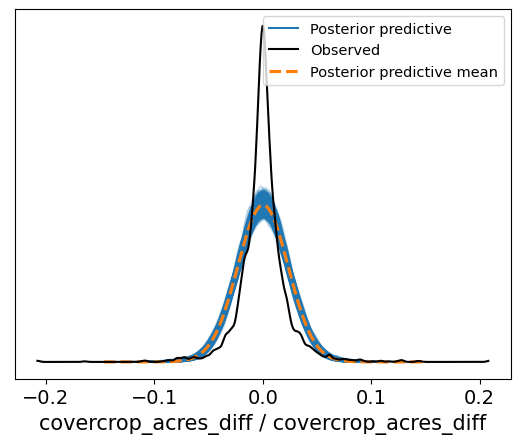

In [26]:
modelccr.predict(trace_ccr, kind="pps")
az.plot_ppc(trace_ccr);

In [39]:
def dfsummary(trace):
    dfy= az.summary(trace)
    dfy['variables'] =dfy.index

    dfy['region']= dfy.variables.str[-2:-1]
    
    return dfy

In [24]:
df=dfsummary(trace_ccr)

In [25]:
df[df['region']== '0']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[0],-0.001,0.009,-0.017,0.015,0.000,0.000,3242.0,3047.0,1.0,1|Region_fips[0],0
cons_prog_income_diff|Region_fips[0],-0.007,0.022,-0.050,0.033,0.000,0.000,5887.0,3303.0,1.0,cons_prog_income_diff|Region_fips[0],0
noncons_prog_income_diff|Region_fips[0],0.000,0.010,-0.018,0.019,0.000,0.000,7825.0,3281.0,1.0,noncons_prog_income_diff|Region_fips[0],0
state_prog_ope_diff|Region_fips[0],0.025,1.443,-3.089,2.793,0.021,0.028,5382.0,1854.0,1.0,state_prog_ope_diff|Region_fips[0],0
insurance_acres_diff|Region_fips[0],0.044,0.054,-0.051,0.150,0.001,0.001,8641.0,3150.0,1.0,insurance_acres_diff|Region_fips[0],0
subsidy_ratio_diff|Region_fips[0],-0.016,0.101,-0.218,0.164,0.001,0.002,7888.0,2946.0,1.0,subsidy_ratio_diff|Region_fips[0],0
edd_mean_diff|Region_fips[0],0.001,0.001,-0.001,0.002,0.000,0.000,6688.0,3387.0,1.0,edd_mean_diff|Region_fips[0],0
pcpdays_mean_diff|Region_fips[0],0.007,0.002,0.003,0.010,0.000,0.000,6527.0,3104.0,1.0,pcpdays_mean_diff|Region_fips[0],0
tavg_std_diff|Region_fips[0],0.013,0.020,-0.023,0.050,0.000,0.000,4989.0,3347.0,1.0,tavg_std_diff|Region_fips[0],0
pcp_mm_std_diff|Region_fips[0],-0.000,0.000,-0.000,-0.000,0.000,0.000,5468.0,2534.0,1.0,pcp_mm_std_diff|Region_fips[0],0


In [26]:
df[df['region']== '1']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[1],-0.000,0.006,-0.011,0.011,0.000,0.000,3466.0,2994.0,1.0,1|Region_fips[1],1
cons_prog_income_diff|Region_fips[1],0.010,0.016,-0.020,0.040,0.000,0.000,7593.0,2433.0,1.0,cons_prog_income_diff|Region_fips[1],1
noncons_prog_income_diff|Region_fips[1],0.006,0.005,-0.004,0.016,0.000,0.000,5224.0,2820.0,1.0,noncons_prog_income_diff|Region_fips[1],1
state_prog_ope_diff|Region_fips[1],0.015,1.404,-2.806,2.748,0.017,0.029,7035.0,2297.0,1.0,state_prog_ope_diff|Region_fips[1],1
insurance_acres_diff|Region_fips[1],-0.040,0.043,-0.124,0.036,0.001,0.001,6686.0,3100.0,1.0,insurance_acres_diff|Region_fips[1],1
subsidy_ratio_diff|Region_fips[1],-0.057,0.065,-0.180,0.062,0.001,0.001,6882.0,3535.0,1.0,subsidy_ratio_diff|Region_fips[1],1
edd_mean_diff|Region_fips[1],0.000,0.001,-0.001,0.001,0.000,0.000,5801.0,3302.0,1.0,edd_mean_diff|Region_fips[1],1
pcpdays_mean_diff|Region_fips[1],0.001,0.003,-0.005,0.007,0.000,0.000,6256.0,3480.0,1.0,pcpdays_mean_diff|Region_fips[1],1
tavg_std_diff|Region_fips[1],-0.005,0.012,-0.028,0.016,0.000,0.000,3708.0,3525.0,1.0,tavg_std_diff|Region_fips[1],1
pcp_mm_std_diff|Region_fips[1],0.000,0.000,-0.000,0.000,0.000,0.000,5133.0,3278.0,1.0,pcp_mm_std_diff|Region_fips[1],1


In [27]:
df[df['region']== '2']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[2],-0.003,0.003,-0.009,0.002,0.000,0.000,3795.0,2823.0,1.00,1|Region_fips[2],2
cons_prog_income_diff|Region_fips[2],-0.020,0.017,-0.053,0.010,0.000,0.000,8319.0,3079.0,1.00,cons_prog_income_diff|Region_fips[2],2
noncons_prog_income_diff|Region_fips[2],0.002,0.002,-0.003,0.006,0.000,0.000,7198.0,3374.0,1.00,noncons_prog_income_diff|Region_fips[2],2
state_prog_ope_diff|Region_fips[2],-0.004,1.340,-2.746,2.637,0.017,0.029,6258.0,1898.0,1.01,state_prog_ope_diff|Region_fips[2],2
insurance_acres_diff|Region_fips[2],0.044,0.020,0.009,0.082,0.000,0.000,7382.0,2912.0,1.00,insurance_acres_diff|Region_fips[2],2
subsidy_ratio_diff|Region_fips[2],0.186,0.062,0.074,0.303,0.001,0.001,7647.0,2579.0,1.00,subsidy_ratio_diff|Region_fips[2],2
edd_mean_diff|Region_fips[2],-0.000,0.000,-0.001,0.001,0.000,0.000,4042.0,3219.0,1.00,edd_mean_diff|Region_fips[2],2
pcpdays_mean_diff|Region_fips[2],0.000,0.001,-0.002,0.002,0.000,0.000,6316.0,3026.0,1.00,pcpdays_mean_diff|Region_fips[2],2
tavg_std_diff|Region_fips[2],-0.014,0.005,-0.024,-0.004,0.000,0.000,4679.0,3298.0,1.00,tavg_std_diff|Region_fips[2],2
pcp_mm_std_diff|Region_fips[2],0.000,0.000,-0.000,0.000,0.000,0.000,7376.0,2888.0,1.00,pcp_mm_std_diff|Region_fips[2],2


In [28]:
df[df['region']== '3']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[3],-0.003,0.004,-0.011,0.004,0.000,0.000,2703.0,2965.0,1.0,1|Region_fips[3],3
cons_prog_income_diff|Region_fips[3],-0.023,0.018,-0.055,0.011,0.000,0.000,5744.0,3324.0,1.0,cons_prog_income_diff|Region_fips[3],3
noncons_prog_income_diff|Region_fips[3],-0.004,0.003,-0.009,0.001,0.000,0.000,7496.0,3053.0,1.0,noncons_prog_income_diff|Region_fips[3],3
state_prog_ope_diff|Region_fips[3],-0.017,1.510,-3.068,2.987,0.020,0.034,6364.0,1701.0,1.0,state_prog_ope_diff|Region_fips[3],3
insurance_acres_diff|Region_fips[3],0.010,0.027,-0.041,0.060,0.000,0.000,8344.0,3000.0,1.0,insurance_acres_diff|Region_fips[3],3
subsidy_ratio_diff|Region_fips[3],0.025,0.085,-0.138,0.184,0.001,0.001,7054.0,2845.0,1.0,subsidy_ratio_diff|Region_fips[3],3
edd_mean_diff|Region_fips[3],0.002,0.000,0.001,0.003,0.000,0.000,4049.0,3195.0,1.0,edd_mean_diff|Region_fips[3],3
pcpdays_mean_diff|Region_fips[3],0.002,0.002,-0.002,0.004,0.000,0.000,6825.0,3201.0,1.0,pcpdays_mean_diff|Region_fips[3],3
tavg_std_diff|Region_fips[3],-0.008,0.008,-0.023,0.007,0.000,0.000,3156.0,3299.0,1.0,tavg_std_diff|Region_fips[3],3
pcp_mm_std_diff|Region_fips[3],-0.000,0.000,-0.000,-0.000,0.000,0.000,6106.0,3275.0,1.0,pcp_mm_std_diff|Region_fips[3],3


In [29]:
df[df['region']== '4']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[4],-0.010,0.003,-0.015,-0.005,0.000,0.000,2941.0,2831.0,1.0,1|Region_fips[4],4
cons_prog_income_diff|Region_fips[4],-0.000,0.009,-0.016,0.017,0.000,0.000,7640.0,3108.0,1.0,cons_prog_income_diff|Region_fips[4],4
noncons_prog_income_diff|Region_fips[4],-0.003,0.002,-0.007,0.001,0.000,0.000,8272.0,2995.0,1.0,noncons_prog_income_diff|Region_fips[4],4
state_prog_ope_diff|Region_fips[4],0.003,1.421,-2.906,2.815,0.018,0.033,6573.0,2253.0,1.0,state_prog_ope_diff|Region_fips[4],4
insurance_acres_diff|Region_fips[4],0.043,0.015,0.015,0.072,0.000,0.000,8748.0,2964.0,1.0,insurance_acres_diff|Region_fips[4],4
subsidy_ratio_diff|Region_fips[4],-0.284,0.080,-0.439,-0.140,0.001,0.001,7309.0,3086.0,1.0,subsidy_ratio_diff|Region_fips[4],4
edd_mean_diff|Region_fips[4],0.001,0.000,0.000,0.001,0.000,0.000,5631.0,3196.0,1.0,edd_mean_diff|Region_fips[4],4
pcpdays_mean_diff|Region_fips[4],0.001,0.001,-0.001,0.002,0.000,0.000,6876.0,3288.0,1.0,pcpdays_mean_diff|Region_fips[4],4
tavg_std_diff|Region_fips[4],-0.016,0.006,-0.028,-0.006,0.000,0.000,6022.0,3222.0,1.0,tavg_std_diff|Region_fips[4],4
pcp_mm_std_diff|Region_fips[4],-0.000,0.000,-0.000,-0.000,0.000,0.000,6656.0,3236.0,1.0,pcp_mm_std_diff|Region_fips[4],4


In [30]:
df[df['region']== '5']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[5],-0.005,0.002,-0.009,-0.001,0.000,0.000,3139.0,2426.0,1.0,1|Region_fips[5],5
cons_prog_income_diff|Region_fips[5],0.005,0.011,-0.016,0.026,0.000,0.000,8739.0,2791.0,1.0,cons_prog_income_diff|Region_fips[5],5
noncons_prog_income_diff|Region_fips[5],0.001,0.002,-0.002,0.004,0.000,0.000,8996.0,3284.0,1.0,noncons_prog_income_diff|Region_fips[5],5
state_prog_ope_diff|Region_fips[5],-0.011,1.415,-2.695,3.012,0.019,0.029,5827.0,2132.0,1.0,state_prog_ope_diff|Region_fips[5],5
insurance_acres_diff|Region_fips[5],0.017,0.013,-0.008,0.042,0.000,0.000,7420.0,2778.0,1.0,insurance_acres_diff|Region_fips[5],5
subsidy_ratio_diff|Region_fips[5],-0.113,0.044,-0.199,-0.036,0.000,0.000,9665.0,2714.0,1.0,subsidy_ratio_diff|Region_fips[5],5
edd_mean_diff|Region_fips[5],-0.001,0.000,-0.001,-0.000,0.000,0.000,5977.0,3445.0,1.0,edd_mean_diff|Region_fips[5],5
pcpdays_mean_diff|Region_fips[5],0.001,0.001,0.000,0.002,0.000,0.000,5931.0,3008.0,1.0,pcpdays_mean_diff|Region_fips[5],5
tavg_std_diff|Region_fips[5],-0.009,0.007,-0.022,0.003,0.000,0.000,6269.0,3105.0,1.0,tavg_std_diff|Region_fips[5],5
pcp_mm_std_diff|Region_fips[5],0.000,0.000,-0.000,0.000,0.000,0.000,7684.0,3266.0,1.0,pcp_mm_std_diff|Region_fips[5],5


In [31]:
df[df['region']== '6']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[6],-0.003,0.004,-0.010,0.005,0.000,0.000,3731.0,2911.0,1.0,1|Region_fips[6],6
cons_prog_income_diff|Region_fips[6],0.011,0.027,-0.040,0.059,0.000,0.000,7832.0,3275.0,1.0,cons_prog_income_diff|Region_fips[6],6
noncons_prog_income_diff|Region_fips[6],0.000,0.007,-0.014,0.014,0.000,0.000,7009.0,3175.0,1.0,noncons_prog_income_diff|Region_fips[6],6
state_prog_ope_diff|Region_fips[6],-0.028,1.385,-2.784,2.859,0.018,0.032,6326.0,1874.0,1.0,state_prog_ope_diff|Region_fips[6],6
insurance_acres_diff|Region_fips[6],0.142,0.031,0.082,0.198,0.000,0.000,8116.0,3059.0,1.0,insurance_acres_diff|Region_fips[6],6
subsidy_ratio_diff|Region_fips[6],0.199,0.104,-0.003,0.387,0.001,0.001,7099.0,2968.0,1.0,subsidy_ratio_diff|Region_fips[6],6
edd_mean_diff|Region_fips[6],-0.000,0.001,-0.001,0.001,0.000,0.000,5609.0,3155.0,1.0,edd_mean_diff|Region_fips[6],6
pcpdays_mean_diff|Region_fips[6],-0.007,0.001,-0.010,-0.004,0.000,0.000,6178.0,2902.0,1.0,pcpdays_mean_diff|Region_fips[6],6
tavg_std_diff|Region_fips[6],-0.015,0.013,-0.038,0.011,0.000,0.000,5065.0,3159.0,1.0,tavg_std_diff|Region_fips[6],6
pcp_mm_std_diff|Region_fips[6],-0.000,0.000,-0.000,-0.000,0.000,0.000,6249.0,3511.0,1.0,pcp_mm_std_diff|Region_fips[6],6


In [64]:

varpost= ['1|Region_fips', 
            'cons_prog_income_diff|Region_fips','state_prog_ope_diff|Region_fips','insurance_acres_diff|Region_fips',
            'subsidy_ratio_diff|Region_fips','noncons_prog_income_diff|Region_fips', #policies
            'edd_mean_diff|Region_fips', 'pcpdays_mean_diff|Region_fips',
            'tavg_std_diff|Region_fips','pcp_mm_std_diff|Region_fips',
            'tavg_z_diff|Region_fips', 'pcp_mm_z_diff|Region_fips',
            'women_acres_diff|Region_fips', #demographics
            'labor_expense_diff|Region_fips', 'org_ope_diff|Region_fips', #farm management
            'pasture_cropland_diff|Region_fips','irrigated_harvcrop_ope_diff|Region_fips','entropy_diff|Region_fips',
            'individual_diff|Region_fips', 'human_diff|Region_fips', 'regulate_diff|Region_fips', #opinion
            'year_2017|Region_fips','year_2022|Region_fips']

varsdf= ['cons',
            'cons_prog_income_diff','state_prog_ope_diff','insurance_acres_diff',
            'subsidy_ratio_diff','noncons_prog_income_diff',#policies
            'edd_mean_diff', 'pcpdays_mean_diff',
            'tavg_std_diff','pcp_mm_std_diff',
            'tavg_z_diff', 'pcp_mm_z_diff',
            'women_acres_diff', #demographics
            'labor_expense_diff', 'org_ope_diff', #farm management
            'pasture_cropland_diff','irrigated_harvcrop_ope_diff','entropy_diff',
            'individual_diff', 'human_diff', 'regulate_diff', #opinion
            'year_2017', 'year_2022']

DF2_clean= DF1
DF2_clean.dropna(axis=0, how='any',subset=['covercrop_acres_diff','women_acres_diff', #demographics
            'labor_expense_diff', 'org_ope_diff', #farm management
            'pasture_cropland_diff','irrigated_harvcrop_ope_diff','entropy_diff', 
            'cons_prog_income_diff','state_prog_ope_diff','insurance_acres_diff',
            'subsidy_ratio_diff','noncons_prog_income_diff', #policies
            'individual_diff', 'human_diff', 'regulate_diff', #opinion
            'edd_mean_diff', 'pcpdays_mean_diff',
            'tavg_std_diff','pcp_mm_std_diff',
            'tavg_z_diff', 'pcp_mm_z_diff',
            'year_2017', 'year_2022'], inplace=True)

In [65]:
mean, lci, uci= r2.Bayesian_Rsquared(DF2_clean,'identity', trace_ccr, 'covercrop_acres_diff',varsdf,varpost, True, 'Region_fips', 4, 1000, 5)
print('Mean CI:', meanp)
print('Lower CI:', lcip)
print('Upper CI:', ucip)

Mean CI: 0.15553873993856665
Lower CI: 0.1403786889669513
Upper CI: 0.17059608249371513


In [66]:
az.compare({"main": trace_ccr, "pooled": trace_ccp})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
main,0,14590.939541,139.441752,0.000000,0.746386,128.713372,0.000000,True,log
pooled,1,14470.694807,30.100486,120.244734,0.253614,129.945954,26.753886,False,log


In [67]:
print('Lower Bound: ', 120.244734-26.753886*2.92)
print('Upper Bound: ', 120.244734+26.753886*2.92)

Lower Bound:  42.12338688
Upper Bound:  198.36608112


In [24]:
def significance(trace, group):
    print('99% CI: ', az.hdi(trace,var_names=varpost[0:12], hdi_prob = 0.99).sel(Region_fips_coord_group_factor=group))
    print('99% CI: ',az.hdi(trace,var_names=varpost[12:], hdi_prob = 0.99).sel(Region_fips_coord_group_factor=group))
    print('90% CI: ',az.hdi(trace,var_names=varpost[0:12], hdi_prob = 0.90).sel(Region_fips_coord_group_factor= group))
    print('90% CI: ',az.hdi(trace,var_names=varpost[12:], hdi_prob = 0.90).sel(Region_fips_coord_group_factor= group))

In [51]:
significance(trace_ccr, '0')

99% CI:  <xarray.Dataset>
Dimensions:                               (hdi: 2)
Coordinates:
    Region_fips_coord_group_factor        <U1 '0'
  * hdi                                   (hdi) <U6 'lower' 'higher'
Data variables:
    1|Region_fips                         (hdi) float64 -0.02112 0.02315
    cons_prog_income_diff|Region_fips     (hdi) float64 -0.06319 0.04936
    state_prog_ope_diff|Region_fips       (hdi) float64 -4.316 5.086
    insurance_acres_diff|Region_fips      (hdi) float64 -0.09233 0.1748
    subsidy_ratio_diff|Region_fips        (hdi) float64 -0.2777 0.2572
    noncons_prog_income_diff|Region_fips  (hdi) float64 -0.02478 0.02586
    edd_mean_diff|Region_fips             (hdi) float64 -0.001072 0.002913
    pcpdays_mean_diff|Region_fips         (hdi) float64 0.001812 0.01132
    tavg_std_diff|Region_fips             (hdi) float64 -0.03464 0.06399
    pcp_mm_std_diff|Region_fips           (hdi) float64 -0.0002398 5.945e-06
    tavg_z_diff|Region_fips               (hdi

In [52]:
significance('1')

99% CI:  <xarray.Dataset>
Dimensions:                               (hdi: 2)
Coordinates:
    Region_fips_coord_group_factor        <U1 '1'
  * hdi                                   (hdi) <U6 'lower' 'higher'
Data variables:
    1|Region_fips                         (hdi) float64 -0.01435 0.01568
    cons_prog_income_diff|Region_fips     (hdi) float64 -0.02921 0.0505
    state_prog_ope_diff|Region_fips       (hdi) float64 -4.015 4.319
    insurance_acres_diff|Region_fips      (hdi) float64 -0.1499 0.06721
    subsidy_ratio_diff|Region_fips        (hdi) float64 -0.2154 0.1154
    noncons_prog_income_diff|Region_fips  (hdi) float64 -0.007765 0.01997
    edd_mean_diff|Region_fips             (hdi) float64 -0.001407 0.001527
    pcpdays_mean_diff|Region_fips         (hdi) float64 -0.006694 0.009402
    tavg_std_diff|Region_fips             (hdi) float64 -0.03677 0.02829
    pcp_mm_std_diff|Region_fips           (hdi) float64 -0.0001316 0.0001925
    tavg_z_diff|Region_fips               (h

In [53]:
significance('2')

99% CI:  <xarray.Dataset>
Dimensions:                               (hdi: 2)
Coordinates:
    Region_fips_coord_group_factor        <U1 '2'
  * hdi                                   (hdi) <U6 'lower' 'higher'
Data variables:
    1|Region_fips                         (hdi) float64 -0.01109 0.004562
    cons_prog_income_diff|Region_fips     (hdi) float64 -0.06687 0.0219
    state_prog_ope_diff|Region_fips       (hdi) float64 -4.456 4.097
    insurance_acres_diff|Region_fips      (hdi) float64 -0.007444 0.0949
    subsidy_ratio_diff|Region_fips        (hdi) float64 0.02266 0.3391
    noncons_prog_income_diff|Region_fips  (hdi) float64 -0.004068 0.007421
    edd_mean_diff|Region_fips             (hdi) float64 -0.001158 0.000918
    pcpdays_mean_diff|Region_fips         (hdi) float64 -0.002459 0.002937
    tavg_std_diff|Region_fips             (hdi) float64 -0.02682 0.0004569
    pcp_mm_std_diff|Region_fips           (hdi) float64 -3.217e-05 5.255e-05
    tavg_z_diff|Region_fips            

In [54]:
significance('3')

99% CI:  <xarray.Dataset>
Dimensions:                               (hdi: 2)
Coordinates:
    Region_fips_coord_group_factor        <U1 '3'
  * hdi                                   (hdi) <U6 'lower' 'higher'
Data variables:
    1|Region_fips                         (hdi) float64 -0.01311 0.007122
    cons_prog_income_diff|Region_fips     (hdi) float64 -0.06752 0.02137
    state_prog_ope_diff|Region_fips       (hdi) float64 -5.214 5.126
    insurance_acres_diff|Region_fips      (hdi) float64 -0.05708 0.07853
    subsidy_ratio_diff|Region_fips        (hdi) float64 -0.2156 0.2332
    noncons_prog_income_diff|Region_fips  (hdi) float64 -0.01047 0.002834
    edd_mean_diff|Region_fips             (hdi) float64 0.0007068 0.003172
    pcpdays_mean_diff|Region_fips         (hdi) float64 -0.003157 0.005547
    tavg_std_diff|Region_fips             (hdi) float64 -0.02805 0.01317
    pcp_mm_std_diff|Region_fips           (hdi) float64 -0.0001697 -1.109e-05
    tavg_z_diff|Region_fips             

In [55]:
significance('4')

99% CI:  <xarray.Dataset>
Dimensions:                               (hdi: 2)
Coordinates:
    Region_fips_coord_group_factor        <U1 '4'
  * hdi                                   (hdi) <U6 'lower' 'higher'
Data variables:
    1|Region_fips                         (hdi) float64 -0.01703 -0.003043
    cons_prog_income_diff|Region_fips     (hdi) float64 -0.02128 0.0245
    state_prog_ope_diff|Region_fips       (hdi) float64 -4.311 4.385
    insurance_acres_diff|Region_fips      (hdi) float64 0.005712 0.08331
    subsidy_ratio_diff|Region_fips        (hdi) float64 -0.4816 -0.08226
    noncons_prog_income_diff|Region_fips  (hdi) float64 -0.008672 0.002973
    edd_mean_diff|Region_fips             (hdi) float64 2.977e-05 0.001449
    pcpdays_mean_diff|Region_fips         (hdi) float64 -0.001149 0.002474
    tavg_std_diff|Region_fips             (hdi) float64 -0.03185 -0.001389
    pcp_mm_std_diff|Region_fips           (hdi) float64 -6.122e-05 -2.25e-06
    tavg_z_diff|Region_fips         

In [56]:
significance('5')

99% CI:  <xarray.Dataset>
Dimensions:                               (hdi: 2)
Coordinates:
    Region_fips_coord_group_factor        <U1 '5'
  * hdi                                   (hdi) <U6 'lower' 'higher'
Data variables:
    1|Region_fips                         (hdi) float64 -0.009979 0.0005211
    cons_prog_income_diff|Region_fips     (hdi) float64 -0.02391 0.03497
    state_prog_ope_diff|Region_fips       (hdi) float64 -4.233 4.708
    insurance_acres_diff|Region_fips      (hdi) float64 -0.01952 0.04996
    subsidy_ratio_diff|Region_fips        (hdi) float64 -0.2238 0.001585
    noncons_prog_income_diff|Region_fips  (hdi) float64 -0.003049 0.004878
    edd_mean_diff|Region_fips             (hdi) float64 -0.001148 -0.0001218
    pcpdays_mean_diff|Region_fips         (hdi) float64 -0.0003348 0.002943
    tavg_std_diff|Region_fips             (hdi) float64 -0.02595 0.007829
    pcp_mm_std_diff|Region_fips           (hdi) float64 -1.641e-05 3.291e-05
    tavg_z_diff|Region_fips     

In [57]:
significance('6')

99% CI:  <xarray.Dataset>
Dimensions:                               (hdi: 2)
Coordinates:
    Region_fips_coord_group_factor        <U1 '6'
  * hdi                                   (hdi) <U6 'lower' 'higher'
Data variables:
    1|Region_fips                         (hdi) float64 -0.01303 0.008121
    cons_prog_income_diff|Region_fips     (hdi) float64 -0.05196 0.08229
    state_prog_ope_diff|Region_fips       (hdi) float64 -4.181 4.359
    insurance_acres_diff|Region_fips      (hdi) float64 0.06752 0.2241
    subsidy_ratio_diff|Region_fips        (hdi) float64 -0.07624 0.4642
    noncons_prog_income_diff|Region_fips  (hdi) float64 -0.01824 0.01917
    edd_mean_diff|Region_fips             (hdi) float64 -0.001839 0.001314
    pcpdays_mean_diff|Region_fips         (hdi) float64 -0.01087 -0.003359
    tavg_std_diff|Region_fips             (hdi) float64 -0.04904 0.0184
    pcp_mm_std_diff|Region_fips           (hdi) float64 -0.0001241 2.081e-05
    tavg_z_diff|Region_fips               (h

### Cover crop adoption in two periods

### 2012-2017 

In [16]:
DF3= DF1[(DF1['year']!= 2022)]
for x in norm_vars:
    DF3[x+'_diff']= DF3[x] - DF3.groupby(['county_fips'])[x].transform('mean')

### Pooled model

In [17]:
sigma1= 1

priorsp={'Intercept': bmb.Prior("Normal", mu=0, sigma=sigma1),
    'women_acres_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'labor_expense_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'org_ope_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pasture_cropland_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'irrigated_harvcrop_ope_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'state_prog_ope_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'entropy_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'cons_prog_income_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'insurance_acres_diff': bmb.Prior("Laplace", mu=0, b=sigma1),    
    'noncons_prog_income_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'subsidy_ratio_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'individual_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'human_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'regulate_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'tavg_std_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'edd_mean_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_std_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcpdays_mean_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'tavg_z_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_z_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'year_2017': bmb.Prior('Laplace', mu=0, b= sigma1),
    'sigma': bmb.Prior('HalfCauchy', beta= 1)
        }

modelpb = bmb.Model("covercrop_acres_diff ~ 0+\
            (cons_prog_income_diff)+(noncons_prog_income_diff)+(state_prog_ope_diff)+\
            (insurance_acres_diff)+(subsidy_ratio_diff)+\
            (edd_mean_diff)+(pcpdays_mean_diff)+\
            (tavg_std_diff)+(pcp_mm_std_diff)+\
            (tavg_z_diff)+(pcp_mm_z_diff)+\
            (women_acres_diff)+(labor_expense_diff)+(org_ope_diff)+\
            (pasture_cropland_diff)+(irrigated_harvcrop_ope_diff)+(entropy_diff)+\
            (individual_diff)+(human_diff)+(regulate_diff)+\
            (year_2017)",
            DF3, priors=priorsp, dropna=True)
modelpb

Formula: covercrop_acres_diff ~ 0+            (cons_prog_income_diff)+(noncons_prog_income_diff)+(state_prog_ope_diff)+            (insurance_acres_diff)+(subsidy_ratio_diff)+            (edd_mean_diff)+(pcpdays_mean_diff)+            (tavg_std_diff)+(pcp_mm_std_diff)+            (tavg_z_diff)+(pcp_mm_z_diff)+            (women_acres_diff)+(labor_expense_diff)+(org_ope_diff)+            (pasture_cropland_diff)+(irrigated_harvcrop_ope_diff)+(entropy_diff)+            (individual_diff)+(human_diff)+(regulate_diff)+            (year_2017)
Family name: Gaussian
Link: identity
Observations: 3986
Priors:
  Common-level effects
    cons_prog_income_diff ~ Laplace(mu: 0, b: 1)
    noncons_prog_income_diff ~ Laplace(mu: 0, b: 1)
    state_prog_ope_diff ~ Laplace(mu: 0, b: 1)
    insurance_acres_diff ~ Laplace(mu: 0, b: 1)
    subsidy_ratio_diff ~ Laplace(mu: 0, b: 1)
    edd_mean_diff ~ Laplace(mu: 0, b: 1)
    pcpdays_mean_diff ~ Laplace(mu: 0, b: 1)
    tavg_std_diff ~ Laplace(mu: 0, b: 1)
  

In [18]:
tracepb = modelpb.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [covercrop_acres_diff_sigma, year_2017, regulate_diff, human_diff, individual_diff, entropy_diff, irrigated_harvcrop_ope_diff, pasture_cropland_diff, org_ope_diff, labor_expense_diff, women_acres_diff, pcp_mm_z_diff, tavg_z_diff, pcp_mm_std_diff, tavg_std_diff, pcpdays_mean_diff, edd_mean_diff, subsidy_ratio_diff, insurance_acres_diff, state_prog_ope_diff, noncons_prog_income_diff, cons_prog_income_diff]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 383 seconds.


In [51]:
az.summary(tracepb)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cons_prog_income_diff,0.002,0.006,-0.009,0.013,0.000,0.000,5531.0,2899.0,1.00
noncons_prog_income_diff,0.007,0.001,0.005,0.009,0.000,0.000,5071.0,3138.0,1.00
state_prog_ope_diff,0.025,1.341,-2.763,2.668,0.018,0.029,5858.0,1911.0,1.01
insurance_acres_diff,0.035,0.010,0.017,0.052,0.000,0.000,5468.0,3005.0,1.00
subsidy_ratio_diff,-0.026,0.026,-0.073,0.022,0.000,0.000,5376.0,2853.0,1.00
edd_mean_diff,-0.000,0.000,-0.001,-0.000,0.000,0.000,4701.0,3172.0,1.00
pcpdays_mean_diff,-0.001,0.000,-0.002,-0.000,0.000,0.000,4482.0,3153.0,1.00
tavg_std_diff,0.002,0.002,-0.001,0.006,0.000,0.000,4622.0,3124.0,1.00
pcp_mm_std_diff,-0.000,0.000,-0.000,-0.000,0.000,0.000,5762.0,3271.0,1.00
tavg_z_diff,-0.004,0.001,-0.006,-0.002,0.000,0.000,4669.0,3082.0,1.00


In [19]:
varpost= [
        'cons_prog_income_diff','noncons_prog_income_diff','state_prog_ope_diff','insurance_acres_diff',
            'subsidy_ratio_diff', #policies
            'edd_mean_diff', 'pcpdays_mean_diff',
            'tavg_std_diff','pcp_mm_std_diff',  #weather
            'tavg_z_diff', 'pcp_mm_z_diff',
             'women_acres_diff', #demographics
            'labor_expense_diff','org_ope_diff', #farm management
            'pasture_cropland_diff','irrigated_harvcrop_ope_diff', 'entropy_diff',
            'individual_diff', 'human_diff', 'regulate_diff', #opinion
            'year_2017']
print(az.hdi(tracepb,var_names=varpost[:12], hdi_prob = 0.99).values())
print(az.hdi(tracepb,var_names=varpost[12:], hdi_prob = 0.99).values())


ValuesView(<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
  * hdi                       (hdi) <U6 'lower' 'higher'
Data variables:
    cons_prog_income_diff     (hdi) float64 -0.01219 0.01643
    noncons_prog_income_diff  (hdi) float64 0.003941 0.00986
    state_prog_ope_diff       (hdi) float64 -4.13 4.273
    insurance_acres_diff      (hdi) float64 0.01008 0.05906
    subsidy_ratio_diff        (hdi) float64 -0.08934 0.03974
    edd_mean_diff             (hdi) float64 -0.0006196 -3.714e-05
    pcpdays_mean_diff         (hdi) float64 -0.001855 0.0001536
    tavg_std_diff             (hdi) float64 -0.002784 0.007041
    pcp_mm_std_diff           (hdi) float64 -3.041e-05 3.261e-06
    tavg_z_diff               (hdi) float64 -0.006325 -0.0009531
    pcp_mm_z_diff             (hdi) float64 -0.008969 -0.003022
    women_acres_diff          (hdi) float64 0.01806 0.05215)
ValuesView(<xarray.Dataset>
Dimensions:                      (hdi: 2)
Coordinates:
  * hdi          

In [20]:
print(az.hdi(tracepb,var_names=varpost[:12], hdi_prob = 0.90).values())
print(az.hdi(tracepb,var_names=varpost[12:], hdi_prob = 0.90).values())

ValuesView(<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
  * hdi                       (hdi) <U6 'lower' 'higher'
Data variables:
    cons_prog_income_diff     (hdi) float64 -0.006819 0.01178
    noncons_prog_income_diff  (hdi) float64 0.005033 0.008832
    state_prog_ope_diff       (hdi) float64 -2.052 2.362
    insurance_acres_diff      (hdi) float64 0.01923 0.05037
    subsidy_ratio_diff        (hdi) float64 -0.06808 0.01492
    edd_mean_diff             (hdi) float64 -0.0005104 -0.0001374
    pcpdays_mean_diff         (hdi) float64 -0.001422 -0.0001475
    tavg_std_diff             (hdi) float64 -0.00112 0.005376
    pcp_mm_std_diff           (hdi) float64 -2.481e-05 -2.962e-06
    tavg_z_diff               (hdi) float64 -0.005305 -0.00191
    pcp_mm_z_diff             (hdi) float64 -0.007964 -0.003983
    women_acres_diff          (hdi) float64 0.02348 0.04519)
ValuesView(<xarray.Dataset>
Dimensions:                      (hdi: 2)
Coordinates:
  * hdi        

### Multiregion

In [21]:
sigma1= 1
priorsr={'1|Region_fips': bmb.Prior("Normal", mu= 0, sigma= sigma1),
    'women_acres_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'labor_expense_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'org_ope_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'irrigated_harvcrop_ope_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pasture_cropland_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'state_prog_ope_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'entropy_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'cons_prog_income_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'insurance_acres_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),    
    'noncons_prog_income_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'subsidy_ratio_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'individual_diff|Region_fips': bmb.Prior("Laplace", mu=0, b= sigma1),
    'human_diff|Region_fips': bmb.Prior("Laplace", mu=0, b= sigma1),
    'regulate_diff|Region_fips': bmb.Prior("Laplace", mu=0, b= sigma1),
    'tavg_std_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'edd_mean_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_std_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcpdays_mean_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'tavg_z_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_z_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'year_2017|Region_fips': bmb.Prior('Laplace', mu=0, b= sigma1),
    'sigma': bmb.Prior('HalfCauchy', beta= sigma1)   
        }

modelrb = bmb.Model("covercrop_acres_diff ~ 0+0+\
            (cons_prog_income_diff|Region_fips)+(noncons_prog_income_diff|Region_fips)+\
            (state_prog_ope_diff|Region_fips)+(insurance_acres_diff|Region_fips)+(subsidy_ratio_diff|Region_fips)+\
            (edd_mean_diff|Region_fips)+(pcpdays_mean_diff|Region_fips)+\
            (tavg_std_diff|Region_fips)+(pcp_mm_std_diff|Region_fips)+\
            (tavg_z_diff|Region_fips)+(pcp_mm_z_diff|Region_fips)+\
            (women_acres_diff|Region_fips)+(labor_expense_diff|Region_fips)+(org_ope_diff|Region_fips)+\
            (pasture_cropland_diff|Region_fips)+(irrigated_harvcrop_ope_diff|Region_fips)+\
            (entropy_diff|Region_fips)+\
            (individual_diff|Region_fips)+(human_diff|Region_fips)+(regulate_diff|Region_fips)+\
            (year_2017|Region_fips)",
            DF3, priors=priorsr, dropna=True)
modelrb

Formula: covercrop_acres_diff ~ 0+0+            (cons_prog_income_diff|Region_fips)+(noncons_prog_income_diff|Region_fips)+            (state_prog_ope_diff|Region_fips)+(insurance_acres_diff|Region_fips)+(subsidy_ratio_diff|Region_fips)+            (edd_mean_diff|Region_fips)+(pcpdays_mean_diff|Region_fips)+            (tavg_std_diff|Region_fips)+(pcp_mm_std_diff|Region_fips)+            (tavg_z_diff|Region_fips)+(pcp_mm_z_diff|Region_fips)+            (women_acres_diff|Region_fips)+(labor_expense_diff|Region_fips)+(org_ope_diff|Region_fips)+            (pasture_cropland_diff|Region_fips)+(irrigated_harvcrop_ope_diff|Region_fips)+            (entropy_diff|Region_fips)+            (individual_diff|Region_fips)+(human_diff|Region_fips)+(regulate_diff|Region_fips)+            (year_2017|Region_fips)
Family name: Gaussian
Link: identity
Observations: 3986
Priors:
  Group-level effects
    1|Region_fips ~ Normal(mu: 0, sigma: 1)
    cons_prog_income_diff|Region_fips ~ Laplace(mu: 0, b: 1)
 

In [22]:
tracerb = modelrb.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [covercrop_acres_diff_sigma, year_2017|Region_fips, regulate_diff|Region_fips, human_diff|Region_fips, individual_diff|Region_fips, entropy_diff|Region_fips, irrigated_harvcrop_ope_diff|Region_fips, pasture_cropland_diff|Region_fips, org_ope_diff|Region_fips, labor_expense_diff|Region_fips, women_acres_diff|Region_fips, pcp_mm_z_diff|Region_fips, tavg_z_diff|Region_fips, pcp_mm_std_diff|Region_fips, tavg_std_diff|Region_fips, pcpdays_mean_diff|Region_fips, edd_mean_diff|Region_fips, subsidy_ratio_diff|Region_fips, insurance_acres_diff|Region_fips, state_prog_ope_diff|Region_fips, noncons_prog_income_diff|Region_fips, cons_prog_income_diff|Region_fips, 1|Region_fips]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15306 seconds.


In [30]:
df1= dfsummary(tracerb)

In [31]:
df1[df1['region']=='0']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[0],0.002,0.005,-0.007,0.010,0.000,0.000,2368.0,2258.0,1.0,1|Region_fips[0],0
cons_prog_income_diff|Region_fips[0],0.002,0.024,-0.043,0.047,0.000,0.000,4510.0,2865.0,1.0,cons_prog_income_diff|Region_fips[0],0
noncons_prog_income_diff|Region_fips[0],-0.009,0.012,-0.032,0.011,0.000,0.000,4218.0,3165.0,1.0,noncons_prog_income_diff|Region_fips[0],0
state_prog_ope_diff|Region_fips[0],-0.012,1.391,-2.799,2.674,0.019,0.025,5531.0,2477.0,1.0,state_prog_ope_diff|Region_fips[0],0
insurance_acres_diff|Region_fips[0],-0.002,0.065,-0.128,0.114,0.001,0.001,5013.0,3128.0,1.0,insurance_acres_diff|Region_fips[0],0
subsidy_ratio_diff|Region_fips[0],-0.082,0.105,-0.275,0.114,0.002,0.001,4394.0,2827.0,1.0,subsidy_ratio_diff|Region_fips[0],0
edd_mean_diff|Region_fips[0],0.000,0.001,-0.002,0.002,0.000,0.000,4278.0,3363.0,1.0,edd_mean_diff|Region_fips[0],0
pcpdays_mean_diff|Region_fips[0],0.002,0.002,-0.002,0.007,0.000,0.000,3876.0,2888.0,1.0,pcpdays_mean_diff|Region_fips[0],0
tavg_std_diff|Region_fips[0],-0.016,0.018,-0.048,0.017,0.000,0.000,3454.0,3298.0,1.0,tavg_std_diff|Region_fips[0],0
pcp_mm_std_diff|Region_fips[0],-0.000,0.000,-0.000,0.000,0.000,0.000,4923.0,3191.0,1.0,pcp_mm_std_diff|Region_fips[0],0


In [32]:
df1[df1['region']=='1']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[1],0.001,0.003,-0.005,0.006,0.000,0.000,3465.0,2753.0,1.0,1|Region_fips[1],1
cons_prog_income_diff|Region_fips[1],-0.008,0.025,-0.054,0.039,0.000,0.000,3690.0,3002.0,1.0,cons_prog_income_diff|Region_fips[1],1
noncons_prog_income_diff|Region_fips[1],0.021,0.012,-0.000,0.043,0.000,0.000,4672.0,3270.0,1.0,noncons_prog_income_diff|Region_fips[1],1
state_prog_ope_diff|Region_fips[1],-0.030,1.334,-2.621,2.661,0.020,0.026,5272.0,1961.0,1.0,state_prog_ope_diff|Region_fips[1],1
insurance_acres_diff|Region_fips[1],-0.014,0.060,-0.127,0.093,0.001,0.001,3487.0,3235.0,1.0,insurance_acres_diff|Region_fips[1],1
subsidy_ratio_diff|Region_fips[1],0.003,0.072,-0.135,0.138,0.001,0.001,5978.0,3485.0,1.0,subsidy_ratio_diff|Region_fips[1],1
edd_mean_diff|Region_fips[1],-0.001,0.001,-0.003,0.001,0.000,0.000,3832.0,3281.0,1.0,edd_mean_diff|Region_fips[1],1
pcpdays_mean_diff|Region_fips[1],-0.004,0.004,-0.012,0.004,0.000,0.000,4014.0,3275.0,1.0,pcpdays_mean_diff|Region_fips[1],1
tavg_std_diff|Region_fips[1],0.012,0.014,-0.015,0.037,0.000,0.000,2769.0,2466.0,1.0,tavg_std_diff|Region_fips[1],1
pcp_mm_std_diff|Region_fips[1],-0.000,0.000,-0.000,0.000,0.000,0.000,3456.0,2815.0,1.0,pcp_mm_std_diff|Region_fips[1],1


In [33]:
df1[df1['region']=='2']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[2],-0.001,0.002,-0.004,0.002,0.000,0.000,3056.0,3048.0,1.0,1|Region_fips[2],2
cons_prog_income_diff|Region_fips[2],0.015,0.022,-0.025,0.055,0.000,0.000,4897.0,3102.0,1.0,cons_prog_income_diff|Region_fips[2],2
noncons_prog_income_diff|Region_fips[2],0.008,0.003,0.002,0.014,0.000,0.000,5574.0,2950.0,1.0,noncons_prog_income_diff|Region_fips[2],2
state_prog_ope_diff|Region_fips[2],0.051,1.408,-2.784,2.876,0.019,0.029,5814.0,2008.0,1.0,state_prog_ope_diff|Region_fips[2],2
insurance_acres_diff|Region_fips[2],0.005,0.025,-0.038,0.054,0.000,0.000,6895.0,3267.0,1.0,insurance_acres_diff|Region_fips[2],2
subsidy_ratio_diff|Region_fips[2],0.002,0.059,-0.104,0.115,0.001,0.001,5829.0,3067.0,1.0,subsidy_ratio_diff|Region_fips[2],2
edd_mean_diff|Region_fips[2],-0.000,0.000,-0.001,0.000,0.000,0.000,3720.0,3134.0,1.0,edd_mean_diff|Region_fips[2],2
pcpdays_mean_diff|Region_fips[2],-0.001,0.001,-0.003,0.001,0.000,0.000,4149.0,2798.0,1.0,pcpdays_mean_diff|Region_fips[2],2
tavg_std_diff|Region_fips[2],-0.012,0.006,-0.023,-0.001,0.000,0.000,3426.0,3012.0,1.0,tavg_std_diff|Region_fips[2],2
pcp_mm_std_diff|Region_fips[2],0.000,0.000,-0.000,0.000,0.000,0.000,4437.0,3357.0,1.0,pcp_mm_std_diff|Region_fips[2],2


In [34]:
df1[df1['region']=='3']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[3],-0.001,0.002,-0.005,0.003,0.000,0.000,2611.0,2769.0,1.0,1|Region_fips[3],3
cons_prog_income_diff|Region_fips[3],-0.014,0.023,-0.058,0.028,0.000,0.000,4502.0,2938.0,1.0,cons_prog_income_diff|Region_fips[3],3
noncons_prog_income_diff|Region_fips[3],-0.003,0.006,-0.013,0.008,0.000,0.000,6034.0,3053.0,1.0,noncons_prog_income_diff|Region_fips[3],3
state_prog_ope_diff|Region_fips[3],-0.011,1.449,-2.954,2.867,0.021,0.030,5122.0,2091.0,1.0,state_prog_ope_diff|Region_fips[3],3
insurance_acres_diff|Region_fips[3],0.036,0.036,-0.030,0.105,0.001,0.000,5124.0,3107.0,1.0,insurance_acres_diff|Region_fips[3],3
subsidy_ratio_diff|Region_fips[3],0.050,0.088,-0.119,0.217,0.001,0.001,4564.0,3045.0,1.0,subsidy_ratio_diff|Region_fips[3],3
edd_mean_diff|Region_fips[3],0.000,0.001,-0.001,0.002,0.000,0.000,3730.0,2869.0,1.0,edd_mean_diff|Region_fips[3],3
pcpdays_mean_diff|Region_fips[3],0.002,0.002,-0.002,0.006,0.000,0.000,4455.0,3304.0,1.0,pcpdays_mean_diff|Region_fips[3],3
tavg_std_diff|Region_fips[3],0.003,0.010,-0.015,0.022,0.000,0.000,3019.0,2937.0,1.0,tavg_std_diff|Region_fips[3],3
pcp_mm_std_diff|Region_fips[3],-0.000,0.000,-0.000,-0.000,0.000,0.000,3746.0,3093.0,1.0,pcp_mm_std_diff|Region_fips[3],3


In [35]:
df1[df1['region']=='4']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[4],-0.004,0.002,-0.007,-0.001,0.000,0.000,3149.0,2693.0,1.0,1|Region_fips[4],4
cons_prog_income_diff|Region_fips[4],-0.008,0.009,-0.025,0.009,0.000,0.000,4342.0,2825.0,1.0,cons_prog_income_diff|Region_fips[4],4
noncons_prog_income_diff|Region_fips[4],0.005,0.003,-0.001,0.011,0.000,0.000,6133.0,3129.0,1.0,noncons_prog_income_diff|Region_fips[4],4
state_prog_ope_diff|Region_fips[4],0.018,1.438,-2.922,2.886,0.020,0.030,5629.0,1997.0,1.0,state_prog_ope_diff|Region_fips[4],4
insurance_acres_diff|Region_fips[4],0.005,0.018,-0.028,0.040,0.000,0.000,4962.0,3300.0,1.0,insurance_acres_diff|Region_fips[4],4
subsidy_ratio_diff|Region_fips[4],-0.277,0.078,-0.409,-0.118,0.001,0.001,5739.0,3206.0,1.0,subsidy_ratio_diff|Region_fips[4],4
edd_mean_diff|Region_fips[4],0.001,0.000,0.000,0.001,0.000,0.000,3548.0,3122.0,1.0,edd_mean_diff|Region_fips[4],4
pcpdays_mean_diff|Region_fips[4],-0.000,0.001,-0.002,0.001,0.000,0.000,4341.0,2968.0,1.0,pcpdays_mean_diff|Region_fips[4],4
tavg_std_diff|Region_fips[4],-0.024,0.007,-0.036,-0.012,0.000,0.000,4014.0,3091.0,1.0,tavg_std_diff|Region_fips[4],4
pcp_mm_std_diff|Region_fips[4],-0.000,0.000,-0.000,0.000,0.000,0.000,6112.0,3274.0,1.0,pcp_mm_std_diff|Region_fips[4],4


In [36]:
df1[df1['region']=='5']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[5],-0.001,0.001,-0.003,0.001,0.000,0.000,3353.0,2999.0,1.0,1|Region_fips[5],5
cons_prog_income_diff|Region_fips[5],0.003,0.013,-0.020,0.028,0.000,0.000,5605.0,2713.0,1.0,cons_prog_income_diff|Region_fips[5],5
noncons_prog_income_diff|Region_fips[5],0.005,0.002,0.002,0.008,0.000,0.000,3762.0,2854.0,1.0,noncons_prog_income_diff|Region_fips[5],5
state_prog_ope_diff|Region_fips[5],0.023,1.391,-2.622,2.921,0.019,0.027,5783.0,2326.0,1.0,state_prog_ope_diff|Region_fips[5],5
insurance_acres_diff|Region_fips[5],0.049,0.017,0.017,0.081,0.000,0.000,7102.0,3300.0,1.0,insurance_acres_diff|Region_fips[5],5
subsidy_ratio_diff|Region_fips[5],-0.041,0.048,-0.131,0.051,0.001,0.001,5459.0,2995.0,1.0,subsidy_ratio_diff|Region_fips[5],5
edd_mean_diff|Region_fips[5],-0.001,0.000,-0.001,-0.000,0.000,0.000,4272.0,2856.0,1.0,edd_mean_diff|Region_fips[5],5
pcpdays_mean_diff|Region_fips[5],-0.000,0.001,-0.002,0.001,0.000,0.000,3983.0,3163.0,1.0,pcpdays_mean_diff|Region_fips[5],5
tavg_std_diff|Region_fips[5],0.018,0.007,0.006,0.031,0.000,0.000,4177.0,3124.0,1.0,tavg_std_diff|Region_fips[5],5
pcp_mm_std_diff|Region_fips[5],0.000,0.000,0.000,0.000,0.000,0.000,4750.0,3062.0,1.0,pcp_mm_std_diff|Region_fips[5],5


In [37]:
df1[df1['region']=='6']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[6],-0.003,0.003,-0.008,0.002,0.000,0.000,2600.0,2646.0,1.0,1|Region_fips[6],6
cons_prog_income_diff|Region_fips[6],0.006,0.031,-0.054,0.063,0.000,0.000,4763.0,3252.0,1.0,cons_prog_income_diff|Region_fips[6],6
noncons_prog_income_diff|Region_fips[6],0.015,0.009,0.000,0.033,0.000,0.000,4992.0,2785.0,1.0,noncons_prog_income_diff|Region_fips[6],6
state_prog_ope_diff|Region_fips[6],0.045,1.384,-2.685,2.749,0.020,0.027,5196.0,2173.0,1.0,state_prog_ope_diff|Region_fips[6],6
insurance_acres_diff|Region_fips[6],0.119,0.039,0.051,0.198,0.001,0.000,4808.0,2953.0,1.0,insurance_acres_diff|Region_fips[6],6
subsidy_ratio_diff|Region_fips[6],0.041,0.113,-0.158,0.269,0.001,0.002,5836.0,2992.0,1.0,subsidy_ratio_diff|Region_fips[6],6
edd_mean_diff|Region_fips[6],0.000,0.001,-0.001,0.001,0.000,0.000,3626.0,2882.0,1.0,edd_mean_diff|Region_fips[6],6
pcpdays_mean_diff|Region_fips[6],-0.010,0.001,-0.013,-0.008,0.000,0.000,4236.0,3274.0,1.0,pcpdays_mean_diff|Region_fips[6],6
tavg_std_diff|Region_fips[6],-0.015,0.019,-0.049,0.023,0.000,0.000,3406.0,2805.0,1.0,tavg_std_diff|Region_fips[6],6
pcp_mm_std_diff|Region_fips[6],-0.000,0.000,-0.000,0.000,0.000,0.000,3546.0,3219.0,1.0,pcp_mm_std_diff|Region_fips[6],6


In [31]:
varpost= ['1|Region_fips', 
            'cons_prog_income_diff|Region_fips','noncons_prog_income_diff|Region_fips',
            'state_prog_ope_diff|Region_fips','insurance_acres_diff|Region_fips',
            'subsidy_ratio_diff|Region_fips', #policies
            'edd_mean_diff|Region_fips', 'pcpdays_mean_diff|Region_fips',
            'tavg_std_diff|Region_fips','pcp_mm_std_diff|Region_fips',
            'tavg_z_diff|Region_fips', 'pcp_mm_z_diff|Region_fips',
            'women_acres_diff|Region_fips', #demographics
            'labor_expense_diff|Region_fips', 'org_ope_diff|Region_fips', #farm management
            'pasture_cropland_diff|Region_fips','irrigated_harvcrop_ope_diff|Region_fips','entropy_diff|Region_fips',
            'individual_diff|Region_fips', 'human_diff|Region_fips', 'regulate_diff|Region_fips', #opinion
            'year_2017|Region_fips']

In [38]:
significance(tracerb, '6')

99% CI:  <xarray.Dataset>
Dimensions:                               (hdi: 2)
Coordinates:
    Region_fips_coord_group_factor        <U1 '6'
  * hdi                                   (hdi) <U6 'lower' 'higher'
Data variables:
    1|Region_fips                         (hdi) float64 -0.009464 0.004067
    cons_prog_income_diff|Region_fips     (hdi) float64 -0.07315 0.08917
    noncons_prog_income_diff|Region_fips  (hdi) float64 -0.006801 0.03704
    state_prog_ope_diff|Region_fips       (hdi) float64 -4.16 4.604
    insurance_acres_diff|Region_fips      (hdi) float64 0.02444 0.2187
    subsidy_ratio_diff|Region_fips        (hdi) float64 -0.2381 0.3416
    edd_mean_diff|Region_fips             (hdi) float64 -0.001487 0.001813
    pcpdays_mean_diff|Region_fips         (hdi) float64 -0.01396 -0.006843
    tavg_std_diff|Region_fips             (hdi) float64 -0.06353 0.0348
    pcp_mm_std_diff|Region_fips           (hdi) float64 -0.0001486 2.042e-05
    tavg_z_diff|Region_fips               (h

### 2017-2022 

In [39]:
DF4= DF1[(DF1['year']!= 2012)]
for x in norm_vars:
    DF4[x+'_diff']= DF4[x] - DF4.groupby(['county_fips'])[x].transform('mean')

In [40]:
sigma1= 1

priorsp={
    'women_acres_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'labor_expense_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'org_ope_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pasture_cropland_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'irrigated_harvcrop_ope_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'state_prog_ope_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'entropy_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'cons_prog_income_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'insurance_acres_diff': bmb.Prior("Laplace", mu=0, b=sigma1),    
    'noncons_prog_income_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'subsidy_ratio_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'individual_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'human_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'regulate_diff': bmb.Prior("Laplace", mu=0, b= sigma1),
    'tavg_std_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'edd_mean_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_std_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcpdays_mean_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'tavg_z_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_z_diff': bmb.Prior("Laplace", mu=0, b=sigma1),
    'year_2022': bmb.Prior('Laplace', mu=0, b= sigma1),
    'sigma': bmb.Prior('HalfCauchy', beta= 1)
        }

modelpa = bmb.Model("covercrop_acres_diff ~ 0+\
            (cons_prog_income_diff)+(noncons_prog_income_diff)+(state_prog_ope_diff)+\
            (insurance_acres_diff)+(subsidy_ratio_diff)+\
            (edd_mean_diff)+(pcpdays_mean_diff)+\
            (tavg_std_diff)+(pcp_mm_std_diff)+\
            (tavg_z_diff)+(pcp_mm_z_diff)+\
            (women_acres_diff)+(labor_expense_diff)+(org_ope_diff)+\
            (pasture_cropland_diff)+(irrigated_harvcrop_ope_diff)+(entropy_diff)+\
            (individual_diff)+(human_diff)+(regulate_diff)+\
            (year_2022)",
            DF4, priors=priorsp, dropna=True)
modelpa

Formula: covercrop_acres_diff ~ 0+            (cons_prog_income_diff)+(noncons_prog_income_diff)+(state_prog_ope_diff)+            (insurance_acres_diff)+(subsidy_ratio_diff)+            (edd_mean_diff)+(pcpdays_mean_diff)+            (tavg_std_diff)+(pcp_mm_std_diff)+            (tavg_z_diff)+(pcp_mm_z_diff)+            (women_acres_diff)+(labor_expense_diff)+(org_ope_diff)+            (pasture_cropland_diff)+(irrigated_harvcrop_ope_diff)+(entropy_diff)+            (individual_diff)+(human_diff)+(regulate_diff)+            (year_2022)
Family name: Gaussian
Link: identity
Observations: 3955
Priors:
  Common-level effects
    cons_prog_income_diff ~ Laplace(mu: 0, b: 1)
    noncons_prog_income_diff ~ Laplace(mu: 0, b: 1)
    state_prog_ope_diff ~ Laplace(mu: 0, b: 1)
    insurance_acres_diff ~ Laplace(mu: 0, b: 1)
    subsidy_ratio_diff ~ Laplace(mu: 0, b: 1)
    edd_mean_diff ~ Laplace(mu: 0, b: 1)
    pcpdays_mean_diff ~ Laplace(mu: 0, b: 1)
    tavg_std_diff ~ Laplace(mu: 0, b: 1)
  

In [41]:
tracepa = modelpa.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [covercrop_acres_diff_sigma, year_2022, regulate_diff, human_diff, individual_diff, entropy_diff, irrigated_harvcrop_ope_diff, pasture_cropland_diff, org_ope_diff, labor_expense_diff, women_acres_diff, pcp_mm_z_diff, tavg_z_diff, pcp_mm_std_diff, tavg_std_diff, pcpdays_mean_diff, edd_mean_diff, subsidy_ratio_diff, insurance_acres_diff, state_prog_ope_diff, noncons_prog_income_diff, cons_prog_income_diff]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 380 seconds.


In [23]:
az.summary(tracepa)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cons_prog_income_diff,0.002,0.007,-0.011,0.015,0.000,0.000,5435.0,2894.0,1.00
noncons_prog_income_diff,0.000,0.001,-0.001,0.002,0.000,0.000,4648.0,3114.0,1.00
state_prog_ope_diff,0.013,1.396,-2.756,2.920,0.019,0.026,5980.0,2329.0,1.01
insurance_acres_diff,0.040,0.010,0.022,0.059,0.000,0.000,5136.0,2809.0,1.00
subsidy_ratio_diff,-0.071,0.035,-0.136,-0.004,0.000,0.000,5210.0,2962.0,1.00
edd_mean_diff,0.000,0.000,-0.000,0.000,0.000,0.000,2792.0,2546.0,1.00
pcpdays_mean_diff,0.001,0.000,-0.000,0.001,0.000,0.000,3625.0,2989.0,1.00
tavg_std_diff,-0.012,0.003,-0.017,-0.006,0.000,0.000,2855.0,3053.0,1.00
pcp_mm_std_diff,-0.000,0.000,-0.000,0.000,0.000,0.000,4990.0,2954.0,1.00
tavg_z_diff,0.008,0.002,0.003,0.012,0.000,0.000,3378.0,2706.0,1.00


In [42]:
varpost= [
        'cons_prog_income_diff','noncons_prog_income_diff','state_prog_ope_diff','insurance_acres_diff',
            'subsidy_ratio_diff', #policies
            'edd_mean_diff', 'pcpdays_mean_diff',
            'tavg_std_diff','pcp_mm_std_diff',  #weather
            'tavg_z_diff', 'pcp_mm_z_diff',
             'women_acres_diff', #demographics
            'labor_expense_diff','org_ope_diff', #farm management
            'pasture_cropland_diff','irrigated_harvcrop_ope_diff', 'entropy_diff',
            'individual_diff', 'human_diff', 'regulate_diff', #opinion
            'year_2022']
print(az.hdi(tracepa,var_names=varpost[:12], hdi_prob = 0.99).values())
print(az.hdi(tracepa,var_names=varpost[12:], hdi_prob = 0.99).values())


ValuesView(<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
  * hdi                       (hdi) <U6 'lower' 'higher'
Data variables:
    cons_prog_income_diff     (hdi) float64 -0.01638 0.01897
    noncons_prog_income_diff  (hdi) float64 -0.002069 0.002899
    state_prog_ope_diff       (hdi) float64 -4.232 4.201
    insurance_acres_diff      (hdi) float64 0.01433 0.06439
    subsidy_ratio_diff        (hdi) float64 -0.1655 0.02343
    edd_mean_diff             (hdi) float64 -0.000234 0.0005047
    pcpdays_mean_diff         (hdi) float64 -0.000341 0.001843
    tavg_std_diff             (hdi) float64 -0.01929 -0.003216
    pcp_mm_std_diff           (hdi) float64 -1.768e-05 1.845e-05
    tavg_z_diff               (hdi) float64 0.001879 0.01374
    pcp_mm_z_diff             (hdi) float64 -0.006922 0.0001873
    women_acres_diff          (hdi) float64 -0.01612 0.0196)
ValuesView(<xarray.Dataset>
Dimensions:                      (hdi: 2)
Coordinates:
  * hdi               

In [43]:
print(az.hdi(tracepa,var_names=varpost[:12], hdi_prob = 0.90).values())
print(az.hdi(tracepa,var_names=varpost[12:], hdi_prob = 0.90).values())


ValuesView(<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
  * hdi                       (hdi) <U6 'lower' 'higher'
Data variables:
    cons_prog_income_diff     (hdi) float64 -0.00942 0.01364
    noncons_prog_income_diff  (hdi) float64 -0.001198 0.002107
    state_prog_ope_diff       (hdi) float64 -2.205 2.494
    insurance_acres_diff      (hdi) float64 0.02396 0.05577
    subsidy_ratio_diff        (hdi) float64 -0.1276 -0.01148
    edd_mean_diff             (hdi) float64 -0.0001029 0.0003748
    pcpdays_mean_diff         (hdi) float64 7.103e-05 0.001437
    tavg_std_diff             (hdi) float64 -0.01674 -0.006661
    pcp_mm_std_diff           (hdi) float64 -1.288e-05 1.035e-05
    tavg_z_diff               (hdi) float64 0.003948 0.01173
    pcp_mm_z_diff             (hdi) float64 -0.005627 -0.001009
    women_acres_diff          (hdi) float64 -0.00953 0.01308)
ValuesView(<xarray.Dataset>
Dimensions:                      (hdi: 2)
Coordinates:
  * hdi            

In [45]:
sigma1= 1
priorsr={'1|Region_fips': bmb.Prior("Normal", mu= 0, sigma= sigma1),
    'women_acres_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'labor_expense_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'org_ope_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'irrigated_harvcrop_ope_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pasture_cropland_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'state_prog_ope_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'entropy_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'cons_prog_income_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'insurance_acres_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),    
    'noncons_prog_income_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'subsidy_ratio_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'individual_diff|Region_fips': bmb.Prior("Laplace", mu=0, b= sigma1),
    'human_diff|Region_fips': bmb.Prior("Laplace", mu=0, b= sigma1),
    'regulate_diff|Region_fips': bmb.Prior("Laplace", mu=0, b= sigma1),
    'tavg_std_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'edd_mean_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_std_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcpdays_mean_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'tavg_z_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'pcp_mm_z_diff|Region_fips': bmb.Prior("Laplace", mu=0, b=sigma1),
    'year_2022|Region_fips': bmb.Prior('Laplace', mu=0, b= sigma1),
    'sigma': bmb.Prior('HalfCauchy', beta= sigma1)   
        }

modelra = bmb.Model("covercrop_acres_diff ~ 0+0+\
            (cons_prog_income_diff|Region_fips)+(noncons_prog_income_diff|Region_fips)+\
            (state_prog_ope_diff|Region_fips)+(insurance_acres_diff|Region_fips)+(subsidy_ratio_diff|Region_fips)+\
            (edd_mean_diff|Region_fips)+(pcpdays_mean_diff|Region_fips)+\
            (tavg_std_diff|Region_fips)+(pcp_mm_std_diff|Region_fips)+\
            (tavg_z_diff|Region_fips)+(pcp_mm_z_diff|Region_fips)+\
            (women_acres_diff|Region_fips)+(labor_expense_diff|Region_fips)+(org_ope_diff|Region_fips)+\
            (pasture_cropland_diff|Region_fips)+(irrigated_harvcrop_ope_diff|Region_fips)+\
            (entropy_diff|Region_fips)+\
            (individual_diff|Region_fips)+(human_diff|Region_fips)+(regulate_diff|Region_fips)+\
            (year_2022|Region_fips)",
            DF4, priors=priorsr, dropna=True)
modelra

Formula: covercrop_acres_diff ~ 0+0+            (cons_prog_income_diff|Region_fips)+(noncons_prog_income_diff|Region_fips)+            (state_prog_ope_diff|Region_fips)+(insurance_acres_diff|Region_fips)+(subsidy_ratio_diff|Region_fips)+            (edd_mean_diff|Region_fips)+(pcpdays_mean_diff|Region_fips)+            (tavg_std_diff|Region_fips)+(pcp_mm_std_diff|Region_fips)+            (tavg_z_diff|Region_fips)+(pcp_mm_z_diff|Region_fips)+            (women_acres_diff|Region_fips)+(labor_expense_diff|Region_fips)+(org_ope_diff|Region_fips)+            (pasture_cropland_diff|Region_fips)+(irrigated_harvcrop_ope_diff|Region_fips)+            (entropy_diff|Region_fips)+            (individual_diff|Region_fips)+(human_diff|Region_fips)+(regulate_diff|Region_fips)+            (year_2022|Region_fips)
Family name: Gaussian
Link: identity
Observations: 3955
Priors:
  Group-level effects
    1|Region_fips ~ Normal(mu: 0, sigma: 1)
    cons_prog_income_diff|Region_fips ~ Laplace(mu: 0, b: 1)
 

In [46]:
tracera = modelra.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [covercrop_acres_diff_sigma, year_2022|Region_fips, regulate_diff|Region_fips, human_diff|Region_fips, individual_diff|Region_fips, entropy_diff|Region_fips, irrigated_harvcrop_ope_diff|Region_fips, pasture_cropland_diff|Region_fips, org_ope_diff|Region_fips, labor_expense_diff|Region_fips, women_acres_diff|Region_fips, pcp_mm_z_diff|Region_fips, tavg_z_diff|Region_fips, pcp_mm_std_diff|Region_fips, tavg_std_diff|Region_fips, pcpdays_mean_diff|Region_fips, edd_mean_diff|Region_fips, subsidy_ratio_diff|Region_fips, insurance_acres_diff|Region_fips, state_prog_ope_diff|Region_fips, noncons_prog_income_diff|Region_fips, cons_prog_income_diff|Region_fips, 1|Region_fips]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57459 seconds.


In [51]:
df2= dfsummary(tracera)

In [39]:
df2[df2['region']=='0']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[0],-0.000,0.002,-0.004,0.004,0.000,0.000,3644.0,2461.0,1.0,1|Region_fips[0],0
cons_prog_income_diff|Region_fips[0],0.045,0.036,-0.027,0.110,0.001,0.001,2635.0,2990.0,1.0,cons_prog_income_diff|Region_fips[0],0
noncons_prog_income_diff|Region_fips[0],-0.025,0.014,-0.052,0.001,0.000,0.000,2770.0,2857.0,1.0,noncons_prog_income_diff|Region_fips[0],0
state_prog_ope_diff|Region_fips[0],-0.007,1.399,-2.593,2.840,0.025,0.029,3569.0,1878.0,1.0,state_prog_ope_diff|Region_fips[0],0
insurance_acres_diff|Region_fips[0],-0.018,0.069,-0.147,0.113,0.001,0.001,4341.0,3099.0,1.0,insurance_acres_diff|Region_fips[0],0
subsidy_ratio_diff|Region_fips[0],-0.314,0.197,-0.678,0.065,0.003,0.002,3369.0,3132.0,1.0,subsidy_ratio_diff|Region_fips[0],0
edd_mean_diff|Region_fips[0],0.001,0.001,-0.002,0.004,0.000,0.000,2646.0,2923.0,1.0,edd_mean_diff|Region_fips[0],0
pcpdays_mean_diff|Region_fips[0],0.007,0.003,0.002,0.013,0.000,0.000,3170.0,3168.0,1.0,pcpdays_mean_diff|Region_fips[0],0
tavg_std_diff|Region_fips[0],0.098,0.036,0.029,0.165,0.001,0.000,2628.0,2947.0,1.0,tavg_std_diff|Region_fips[0],0
pcp_mm_std_diff|Region_fips[0],-0.000,0.000,-0.000,-0.000,0.000,0.000,3266.0,2929.0,1.0,pcp_mm_std_diff|Region_fips[0],0


In [52]:
df2[df2['region']=='1']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[1],-0.001,0.003,-0.007,0.005,0.000,0.000,2542.0,2316.0,1.0,1|Region_fips[1],1
cons_prog_income_diff|Region_fips[1],0.027,0.026,-0.022,0.074,0.000,0.000,2806.0,2449.0,1.0,cons_prog_income_diff|Region_fips[1],1
noncons_prog_income_diff|Region_fips[1],0.014,0.007,0.001,0.027,0.000,0.000,2074.0,2659.0,1.0,noncons_prog_income_diff|Region_fips[1],1
state_prog_ope_diff|Region_fips[1],0.037,1.352,-2.461,2.903,0.023,0.026,3853.0,1867.0,1.0,state_prog_ope_diff|Region_fips[1],1
insurance_acres_diff|Region_fips[1],-0.016,0.054,-0.121,0.082,0.001,0.001,3398.0,3109.0,1.0,insurance_acres_diff|Region_fips[1],1
subsidy_ratio_diff|Region_fips[1],-0.042,0.138,-0.299,0.220,0.002,0.002,3087.0,3041.0,1.0,subsidy_ratio_diff|Region_fips[1],1
edd_mean_diff|Region_fips[1],-0.001,0.001,-0.002,0.001,0.000,0.000,2550.0,2947.0,1.0,edd_mean_diff|Region_fips[1],1
pcpdays_mean_diff|Region_fips[1],0.004,0.006,-0.006,0.015,0.000,0.000,1621.0,2061.0,1.0,pcpdays_mean_diff|Region_fips[1],1
tavg_std_diff|Region_fips[1],0.009,0.029,-0.044,0.063,0.001,0.000,1906.0,2445.0,1.0,tavg_std_diff|Region_fips[1],1
pcp_mm_std_diff|Region_fips[1],0.000,0.000,-0.000,0.000,0.000,0.000,2614.0,3207.0,1.0,pcp_mm_std_diff|Region_fips[1],1


In [41]:
df2[df2['region']=='2']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[2],-0.000,0.001,-0.002,0.002,0.000,0.000,2909.0,2669.0,1.0,1|Region_fips[2],2
cons_prog_income_diff|Region_fips[2],-0.019,0.018,-0.054,0.014,0.000,0.000,4278.0,3562.0,1.0,cons_prog_income_diff|Region_fips[2],2
noncons_prog_income_diff|Region_fips[2],0.001,0.002,-0.003,0.005,0.000,0.000,4002.0,3415.0,1.0,noncons_prog_income_diff|Region_fips[2],2
state_prog_ope_diff|Region_fips[2],-0.031,1.383,-3.040,2.475,0.020,0.029,5199.0,2031.0,1.0,state_prog_ope_diff|Region_fips[2],2
insurance_acres_diff|Region_fips[2],0.063,0.023,0.021,0.106,0.000,0.000,5312.0,2993.0,1.0,insurance_acres_diff|Region_fips[2],2
subsidy_ratio_diff|Region_fips[2],0.063,0.095,-0.118,0.245,0.001,0.001,4547.0,3150.0,1.0,subsidy_ratio_diff|Region_fips[2],2
edd_mean_diff|Region_fips[2],0.000,0.001,-0.001,0.001,0.000,0.000,2930.0,3270.0,1.0,edd_mean_diff|Region_fips[2],2
pcpdays_mean_diff|Region_fips[2],0.001,0.001,-0.001,0.004,0.000,0.000,3338.0,2770.0,1.0,pcpdays_mean_diff|Region_fips[2],2
tavg_std_diff|Region_fips[2],-0.001,0.008,-0.016,0.013,0.000,0.000,2817.0,2925.0,1.0,tavg_std_diff|Region_fips[2],2
pcp_mm_std_diff|Region_fips[2],0.000,0.000,-0.000,0.000,0.000,0.000,5031.0,3529.0,1.0,pcp_mm_std_diff|Region_fips[2],2


In [42]:
df2[df2['region']=='3']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[3],-0.000,0.001,-0.002,0.002,0.000,0.000,3478.0,2837.0,1.0,1|Region_fips[3],3
cons_prog_income_diff|Region_fips[3],-0.013,0.025,-0.062,0.032,0.000,0.000,4386.0,3423.0,1.0,cons_prog_income_diff|Region_fips[3],3
noncons_prog_income_diff|Region_fips[3],-0.001,0.003,-0.006,0.004,0.000,0.000,4952.0,3309.0,1.0,noncons_prog_income_diff|Region_fips[3],3
state_prog_ope_diff|Region_fips[3],0.041,1.379,-2.673,2.733,0.020,0.025,4940.0,2248.0,1.0,state_prog_ope_diff|Region_fips[3],3
insurance_acres_diff|Region_fips[3],-0.017,0.034,-0.079,0.046,0.001,0.000,4364.0,2561.0,1.0,insurance_acres_diff|Region_fips[3],3
subsidy_ratio_diff|Region_fips[3],-0.029,0.139,-0.285,0.234,0.002,0.002,5213.0,3056.0,1.0,subsidy_ratio_diff|Region_fips[3],3
edd_mean_diff|Region_fips[3],0.002,0.001,0.000,0.003,0.000,0.000,2671.0,2764.0,1.0,edd_mean_diff|Region_fips[3],3
pcpdays_mean_diff|Region_fips[3],-0.002,0.002,-0.006,0.002,0.000,0.000,3241.0,3239.0,1.0,pcpdays_mean_diff|Region_fips[3],3
tavg_std_diff|Region_fips[3],0.002,0.012,-0.021,0.025,0.000,0.000,3221.0,3044.0,1.0,tavg_std_diff|Region_fips[3],3
pcp_mm_std_diff|Region_fips[3],-0.000,0.000,-0.000,-0.000,0.000,0.000,3164.0,3031.0,1.0,pcp_mm_std_diff|Region_fips[3],3


In [46]:
df2[df2['region']=='4']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[4],0.000,0.001,-0.002,0.002,0.000,0.000,2834.0,2161.0,1.0,1|Region_fips[4],4
cons_prog_income_diff|Region_fips[4],-0.006,0.014,-0.031,0.019,0.000,0.000,4850.0,3184.0,1.0,cons_prog_income_diff|Region_fips[4],4
noncons_prog_income_diff|Region_fips[4],-0.001,0.002,-0.005,0.003,0.000,0.000,4723.0,3212.0,1.0,noncons_prog_income_diff|Region_fips[4],4
state_prog_ope_diff|Region_fips[4],0.006,1.377,-2.718,2.779,0.023,0.027,3893.0,2085.0,1.0,state_prog_ope_diff|Region_fips[4],4
insurance_acres_diff|Region_fips[4],0.022,0.018,-0.012,0.055,0.000,0.000,5242.0,2849.0,1.0,insurance_acres_diff|Region_fips[4],4
subsidy_ratio_diff|Region_fips[4],-0.312,0.125,-0.571,-0.096,0.002,0.001,4521.0,2628.0,1.0,subsidy_ratio_diff|Region_fips[4],4
edd_mean_diff|Region_fips[4],0.001,0.000,-0.000,0.001,0.000,0.000,3081.0,2701.0,1.0,edd_mean_diff|Region_fips[4],4
pcpdays_mean_diff|Region_fips[4],0.001,0.001,-0.001,0.002,0.000,0.000,4171.0,3597.0,1.0,pcpdays_mean_diff|Region_fips[4],4
tavg_std_diff|Region_fips[4],0.001,0.008,-0.014,0.016,0.000,0.000,4590.0,3012.0,1.0,tavg_std_diff|Region_fips[4],4
pcp_mm_std_diff|Region_fips[4],0.000,0.000,0.000,0.000,0.000,0.000,4417.0,3136.0,1.0,pcp_mm_std_diff|Region_fips[4],4


In [56]:
df2[df2['region']=='5']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[5],-0.001,0.001,-0.003,0.002,0.000,0.000,2486.0,2831.0,1.0,1|Region_fips[5],5
cons_prog_income_diff|Region_fips[5],0.063,0.016,0.034,0.095,0.000,0.000,5282.0,2805.0,1.0,cons_prog_income_diff|Region_fips[5],5
noncons_prog_income_diff|Region_fips[5],0.000,0.002,-0.003,0.003,0.000,0.000,4613.0,3397.0,1.0,noncons_prog_income_diff|Region_fips[5],5
state_prog_ope_diff|Region_fips[5],0.029,1.368,-2.800,2.556,0.021,0.029,4838.0,1919.0,1.0,state_prog_ope_diff|Region_fips[5],5
insurance_acres_diff|Region_fips[5],0.028,0.017,-0.003,0.059,0.000,0.000,5254.0,3020.0,1.0,insurance_acres_diff|Region_fips[5],5
subsidy_ratio_diff|Region_fips[5],-0.045,0.051,-0.136,0.054,0.001,0.001,5000.0,2929.0,1.0,subsidy_ratio_diff|Region_fips[5],5
edd_mean_diff|Region_fips[5],-0.001,0.000,-0.001,-0.000,0.000,0.000,2566.0,2798.0,1.0,edd_mean_diff|Region_fips[5],5
pcpdays_mean_diff|Region_fips[5],0.000,0.001,-0.001,0.002,0.000,0.000,2462.0,2682.0,1.0,pcpdays_mean_diff|Region_fips[5],5
tavg_std_diff|Region_fips[5],-0.009,0.010,-0.028,0.009,0.000,0.000,4226.0,3294.0,1.0,tavg_std_diff|Region_fips[5],5
pcp_mm_std_diff|Region_fips[5],-0.000,0.000,-0.000,-0.000,0.000,0.000,3856.0,2840.0,1.0,pcp_mm_std_diff|Region_fips[5],5


In [48]:
df2[df2['region']=='6']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,region
1|Region_fips[6],0.000,0.001,-0.002,0.003,0.000,0.000,3372.0,2479.0,1.00,1|Region_fips[6],6
cons_prog_income_diff|Region_fips[6],0.049,0.032,-0.010,0.110,0.000,0.000,4439.0,2888.0,1.00,cons_prog_income_diff|Region_fips[6],6
noncons_prog_income_diff|Region_fips[6],0.001,0.009,-0.017,0.017,0.000,0.000,4926.0,2934.0,1.01,noncons_prog_income_diff|Region_fips[6],6
state_prog_ope_diff|Region_fips[6],-0.007,1.464,-2.965,2.931,0.025,0.030,4010.0,1874.0,1.00,state_prog_ope_diff|Region_fips[6],6
insurance_acres_diff|Region_fips[6],0.168,0.042,0.085,0.244,0.001,0.000,4699.0,2692.0,1.00,insurance_acres_diff|Region_fips[6],6
subsidy_ratio_diff|Region_fips[6],-0.071,0.145,-0.334,0.214,0.002,0.002,5439.0,3148.0,1.00,subsidy_ratio_diff|Region_fips[6],6
edd_mean_diff|Region_fips[6],-0.002,0.001,-0.003,-0.000,0.000,0.000,3575.0,2774.0,1.00,edd_mean_diff|Region_fips[6],6
pcpdays_mean_diff|Region_fips[6],-0.004,0.002,-0.008,-0.000,0.000,0.000,3129.0,2853.0,1.00,pcpdays_mean_diff|Region_fips[6],6
tavg_std_diff|Region_fips[6],-0.033,0.018,-0.067,0.000,0.000,0.000,4139.0,3050.0,1.00,tavg_std_diff|Region_fips[6],6
pcp_mm_std_diff|Region_fips[6],-0.000,0.000,-0.000,-0.000,0.000,0.000,4794.0,3121.0,1.00,pcp_mm_std_diff|Region_fips[6],6


In [47]:
varpost= ['1|Region_fips', 
            'cons_prog_income_diff|Region_fips','noncons_prog_income_diff|Region_fips',
            'state_prog_ope_diff|Region_fips','insurance_acres_diff|Region_fips',
            'subsidy_ratio_diff|Region_fips', #policies
            'edd_mean_diff|Region_fips', 'pcpdays_mean_diff|Region_fips',
            'tavg_std_diff|Region_fips','pcp_mm_std_diff|Region_fips',
            'tavg_z_diff|Region_fips', 'pcp_mm_z_diff|Region_fips',
            'women_acres_diff|Region_fips', #demographics
            'labor_expense_diff|Region_fips', 'org_ope_diff|Region_fips', #farm management
            'pasture_cropland_diff|Region_fips','irrigated_harvcrop_ope_diff|Region_fips','entropy_diff|Region_fips',
            'individual_diff|Region_fips', 'human_diff|Region_fips', 'regulate_diff|Region_fips', #opinion
            'year_2022|Region_fips']

In [57]:
significance(tracera, '6')

99% CI:  <xarray.Dataset>
Dimensions:                               (hdi: 2)
Coordinates:
    Region_fips_coord_group_factor        <U1 '6'
  * hdi                                   (hdi) <U6 'lower' 'higher'
Data variables:
    1|Region_fips                         (hdi) float64 -0.00653 0.009622
    cons_prog_income_diff|Region_fips     (hdi) float64 -0.04086 0.1241
    noncons_prog_income_diff|Region_fips  (hdi) float64 -0.0221 0.0228
    state_prog_ope_diff|Region_fips       (hdi) float64 -4.499 4.331
    insurance_acres_diff|Region_fips      (hdi) float64 0.06098 0.2723
    subsidy_ratio_diff|Region_fips        (hdi) float64 -0.4458 0.2912
    edd_mean_diff|Region_fips             (hdi) float64 -0.003645 0.0005853
    pcpdays_mean_diff|Region_fips         (hdi) float64 -0.008954 0.000848
    tavg_std_diff|Region_fips             (hdi) float64 -0.07527 0.01377
    pcp_mm_std_diff|Region_fips           (hdi) float64 -0.0001689 1.403e-05
    tavg_z_diff|Region_fips               (hdi